In [1]:
# Install required packages
!pip install librosa tensorflow-hub panns-inference kagglehub tqdm

In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
import tensorflow_hub as hub
import torch
import torchaudio
from tqdm import tqdm
import warnings
import kagglehub
warnings.filterwarnings('ignore')

In [3]:
# Check GPU availability
print("GPU Available:", tf.config.experimental.list_physical_devices('GPU'))
print("CUDA Available:", torch.cuda.is_available())


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CUDA Available: True


In [4]:
# ==========================================
# STEP 2: Download Dataset
# ==========================================

print("Downloading dataset...")
dataset_path = kagglehub.dataset_download("murtadhanajim/gender-recognition-by-voiceoriginal")
print(f"Dataset downloaded to: {dataset_path}")

100%|██████████| 1.31G/1.31G [01:06<00:00, 21.3MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/murtadhanajim/gender-recognition-by-voiceoriginal/versions/1


In [5]:
# ==========================================
# STEP 3: Model Loading Functions
# ==========================================

import tensorflow as tf

class AudioFeatureExtractor:
    def __init__(self):
        """Initialize the three pre-trained models"""
        print("Loading pre-trained models")

        """
        In our baseline paper, the authors extracted the signal features using the following PTMs;
        VGGish, YAMNet, and PANNs with 128, 1024 and 2048 dimensions respectively.
        We replicated the same feature extraction pipeline as mentioned in the paper for our project.
        """

        # 1. VGGish Model (128-dimensional features)
        print("Loading VGGish...")
        self.vggish_model = hub.load('https://tfhub.dev/google/vggish/1')

        # 2. YAMNet Model (1024-dimensional features)
        print("Loading YAMNet...")
        self.yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

        # 3. PANNs Model (2048-dimensional features)
        print("Setting up PANNs...")
        self.setup_panns()

        print("All models loaded successfully!")

    def setup_panns(self):
        """Setup PANNs model"""
        try:
            from panns_inference import AudioTagging
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            self.panns_model = AudioTagging(checkpoint_path=None, device=device)
            print(f"PANNs loaded on {device}")
        except Exception as e:
            print(f"Error loading PANNs: {e}")
            print("Installing panns_inference...")
            !pip install panns_inference
            from panns_inference import AudioTagging
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            self.panns_model = AudioTagging(checkpoint_path=None, device=device)

    def load_audio(self, file_path, target_sr=16000):
        """Load and preprocess audio file with error handling"""
        try:
            audio, sr = librosa.load(file_path, sr=target_sr, mono=True, duration=4.0)
            return audio, sr
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return None, None

    def extract_vggish_features(self, audio, sr=16000):
        """VGGish feature extraction with NaN handling"""
        try:
            # Handle empty/short audio (minimum 0.96s required by VGGish)
            if len(audio) < 960:  # 0.96s * 16000 Hz
                print(f"Audio too short ({len(audio)/sr:.2f}s), returning zeros")
                return np.zeros(128)

            # Convert to TensorFlow tensor
            audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)

            # Extract embeddings, returns features for each 0.96s segment
            embeddings = self.vggish_model(audio_tensor)

            # Check for NaN immediately
            if tf.reduce_any(tf.math.is_nan(embeddings)):
                print("NaN detected in embeddings, using zeros")
                return np.zeros(128)

            # Average across time dimension
            if len(embeddings.shape) > 1:
                features = tf.reduce_mean(embeddings, axis=0)
            else:
                features = embeddings

            # Convert to numpy and final NaN check
            features_np = features.numpy()
            if np.isnan(features_np).any():
                print("NaN in final features, using zeros")
                return np.zeros(128)

            return features_np

        except Exception as e:
            print(f"VGGish extraction error: {e}")
            return np.zeros(128)

    def extract_yamnet_features(self, audio, sr=16000):
        """YAMNet feature extraction with error handling"""
        try:
            if len(audio) == 0:
                return np.zeros(1024)

            audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)

            # Get YAMNet outputs: scores, embeddings, spectrogram
            scores, embeddings, spectrogram = self.yamnet_model(audio_tensor)

            # Check for NaN
            if tf.reduce_any(tf.math.is_nan(embeddings)):
                print("NaN detected in YAMNet embeddings, using zeros")
                return np.zeros(1024)

            # Average embeddings across time
            if len(embeddings.shape) > 1:
                features = tf.reduce_mean(embeddings, axis=0)
            else:
                features = embeddings

            # Final NaN check
            features_np = features.numpy()
            if np.isnan(features_np).any():
                print("NaN in final YAMNet features, using zeros")
                return np.zeros(1024)

            return features_np

        except Exception as e:
            print(f"YAMNet extraction error: {e}")
            return np.zeros(1024)

    def extract_panns_features(self, audio, sr=16000):
      """PANNs feature extraction with error handling"""
      try:
          if len(audio) == 0:
              return np.zeros(2048)

          if sr != 32000:
              audio_32k = librosa.resample(audio, orig_sr=sr, target_sr=32000)
          else:
              audio_32k = audio

          # Check minimum length
          if len(audio_32k) < 32000:
              return np.zeros(2048)

          # Get inference
          (clipwise_output, embedding) = self.panns_model.inference(audio_32k[None, :])

          # Convert to numpy
          if isinstance(embedding, torch.Tensor):
              embedding = embedding.cpu().numpy()

          # Check for NaN using NumPy
          if np.isnan(embedding).any():
              return np.zeros(2048)

          # Handle embedding shape
          embedding = embedding.squeeze()
          if embedding.ndim == 0:  # Scalar case
              return np.zeros(2048)
          elif embedding.size > 2048:
              return embedding[:2048]
          elif embedding.size < 2048:
              padded = np.zeros(2048)
              padded[:embedding.size] = embedding
              return padded
          return embedding

      except Exception as e:
          print(f"PANNs extraction error: {e}")
          return np.zeros(2048)

    def extract_all_features(self, file_path):
        """Extract features from all three models for a single audio file"""
        # Load audio at 16kHz
        audio, sr = self.load_audio(file_path, target_sr=16000)

        if audio is None:
            return {
                'vggish': np.zeros(128),
                'yamnet': np.zeros(1024),
                'panns': np.zeros(2048)
            }

        # Extract features from each model
        features = {
            'vggish': self.extract_vggish_features(audio, sr),
            'yamnet': self.extract_yamnet_features(audio, sr),
            'panns': self.extract_panns_features(audio, sr)
        }

        return features




In [6]:

# ==========================================
# STEP 4: Dataset Processing Function
# ==========================================

def process_gender_dataset(dataset_path, output_dir='./audio_features'):
    """Process the gender recognition dataset and extract features with fixed labeling"""
    os.makedirs(output_dir, exist_ok=True)

    # Initialize extractor
    print("Initializing feature extractor...")
    extractor = AudioFeatureExtractor()

    # Find all audio files
    audio_extensions = ['.wav', '.mp3', '.flac', '.m4a', '.ogg']
    audio_files = []

    print("Scanning for audio files...")
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in audio_extensions):
                audio_files.append(os.path.join(root, file))

    print(f"Found {len(audio_files)} audio files")

    if len(audio_files) == 0:
        print("No audio files found! Please check the dataset path.")
        return None, None

    # Initialize feature storage
    features_dict = {
        'vggish': [],
        'yamnet': [],
        'panns': []
    }

    file_metadata = []
    failed_files = 0

    # Process each file

    print("Extracting features...")
    male_count = 0
    female_count = 0
    unknown_count = 0

    for i, file_path in enumerate(tqdm(audio_files, desc="Processing audio files")):
        try:
            # Extract features
            features = extractor.extract_all_features(file_path)

            # Store features
            features_dict['vggish'].append(features['vggish'])
            features_dict['yamnet'].append(features['yamnet'])
            features_dict['panns'].append(features['panns'])

            # Extract gender from directory structure
            gender = 'unknown'
            path_parts = file_path.lower().split(os.sep)

            # Check all directory levels for gender indicators
            if 'female' in path_parts:
                gender = 'female'
                female_count += 1
            elif 'male' in path_parts:
                gender = 'male'
                male_count += 1
            else:
                # Try to detect from filename
                if 'female' in os.path.basename(file_path).lower():
                    gender = 'female'
                    female_count += 1
                elif 'male' in os.path.basename(file_path).lower():
                    gender = 'male'
                    male_count += 1
                else:
                    gender = 'unknown'
                    unknown_count += 1

            file_metadata.append({
                'index': i,
                'filename': os.path.basename(file_path),
                'file_path': file_path,
                'gender': gender
            })

        except Exception as e:
            failed_files += 1
            print(f"Error processing {file_path}: {e}")
            features_dict['vggish'].append(np.zeros(128))
            features_dict['yamnet'].append(np.zeros(1024))
            features_dict['panns'].append(np.zeros(2048))
            file_metadata.append({
                'index': i,
                'filename': os.path.basename(file_path),
                'file_path': file_path,
                'gender': 'unknown'
            })

    print(f"Failed to process {failed_files}/{len(audio_files)} files")

    print(f"Gender detection results:")
    print(f" - Male: {male_count}")
    print(f" - Female: {female_count}")
    print(f" - Unknown: {unknown_count}")


    # Convert to numpy arrays
    for model_name in features_dict:
        features_dict[model_name] = np.array(features_dict[model_name])
        print(f"{model_name.upper()} features shape: {features_dict[model_name].shape}")

    # Save features
    print("Saving extracted features...")
    for model_name, features_array in features_dict.items():
        np.save(os.path.join(output_dir, f'{model_name}_features.npy'), features_array)

    # Save metadata
    metadata_df = pd.DataFrame(file_metadata)
    metadata_df.to_csv(os.path.join(output_dir, 'file_metadata.csv'), index=False)

    print(f"Features saved to: {output_dir}")

    # Clean NaN values
    clean_features(output_dir)

    return features_dict, metadata_df


In [7]:
# ==========================================
# Feature Cleaning Function
# ==========================================

def clean_features(features_dir='./audio_features'):
    """Clean NaN values from features and update metadata"""
    print("Cleaning NaN values from features...")
    features = {
        'vggish': np.load(os.path.join(features_dir, 'vggish_features.npy')),
        'yamnet': np.load(os.path.join(features_dir, 'yamnet_features.npy')),
        'panns': np.load(os.path.join(features_dir, 'panns_features.npy'))
    }
    metadata = pd.read_csv(os.path.join(features_dir, 'file_metadata.csv'))

    # Identify NaN rows in VGGish
    nan_mask = np.isnan(features['vggish']).any(axis=1)
    nan_count = nan_mask.sum()
    print(f"Found {nan_count} files with NaN values in VGGish features")

    # Remove NaN rows from all features and metadata
    if nan_count > 0:
        for model in features:
            features[model] = features[model][~nan_mask]
        metadata = metadata[~nan_mask]

        # Save cleaned versions
        np.save(os.path.join(features_dir, 'vggish_features.npy'), features['vggish'])
        np.save(os.path.join(features_dir, 'yamnet_features.npy'), features['yamnet'])
        np.save(os.path.join(features_dir, 'panns_features.npy'), features['panns'])
        metadata.to_csv(os.path.join(features_dir, 'file_metadata.csv'), index=False)
        print(f"Saved cleaned features without {nan_count} NaN entries")

    # Verify all features
    for model, array in features.items():
        nan_count = np.isnan(array).sum()
        print(f"{model.upper()} NaN count after cleaning: {nan_count}")

    return features, metadata

In [8]:
# ==========================================
# STEP 5: Execute Feature Extraction
# ==========================================

print("Starting feature extraction process...")
features, metadata = process_gender_dataset(dataset_path)

if features is not None:
    print("\n" + "="*50)
    print("FEATURE EXTRACTION COMPLETED SUCCESSFULLY!")
    print("="*50)

    # Display final results
    print("Feature dimensions match paper specifications:")
    print(f"✓ VGGish: {features['vggish'].shape[1]} dimensions (expected: 128)")
    print(f"✓ YAMNet: {features['yamnet'].shape[1]} dimensions (expected: 1024)")
    print(f"✓ PANNs: {features['panns'].shape[1]} dimensions (expected: 2048)")

    print("\nFeature statistics after cleaning:")
    for model in ['vggish', 'yamnet', 'panns']:
        array = features[model]
        print(f"\n{model.upper()} Features:")
        print(f"  Shape: {array.shape}")
        print(f"  Mean: {np.mean(array):.4f}")
        print(f"  Std: {np.std(array):.4f}")
        print(f"  Min: {np.min(array):.4f}")
        print(f"  Max: {np.max(array):.4f}")
        print(f"  NaN count: {np.isnan(array).sum()}")

    # Gender distribution
    print("\nGender Distribution:")
    print(metadata['gender'].value_counts())

    print(f"\nFeatures saved in './audio_features/' directory")
    print("Files created:")
    print("- vggish_features.npy")
    print("- yamnet_features.npy")
    print("- panns_features.npy")
    print("- file_metadata.csv")

else:
    print("Feature extraction failed. Please check the dataset path and file formats.")

Starting feature extraction process...
Initializing feature extractor...
Loading pre-trained models
Loading VGGish...
Loading YAMNet...
Setting up PANNs...
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
GPU number: 1
PANNs loaded on cuda
All models loaded successfully!
Scanning for audio files...
Found 16148 audio files
Extracting features...


Processing audio files:  23%|██▎       | 3783/16148 [01:37<05:49, 35.35it/s]

NaN in final features, using zeros


Processing audio files:  40%|████      | 6506/16148 [02:41<03:56, 40.77it/s]

NaN in final features, using zeros


Processing audio files:  62%|██████▏   | 10048/16148 [04:03<02:17, 44.49it/s]

NaN in final features, using zeros


Processing audio files:  66%|██████▌   | 10680/16148 [04:18<02:19, 39.08it/s]

NaN in final features, using zeros


Processing audio files: 100%|██████████| 16148/16148 [06:26<00:00, 41.75it/s]


Failed to process 0/16148 files
Gender detection results:
 - Male: 10380
 - Female: 5768
 - Unknown: 0
VGGISH features shape: (16148, 128)
YAMNET features shape: (16148, 1024)
PANNS features shape: (16148, 2048)
Saving extracted features...
Features saved to: ./audio_features
Cleaning NaN values from features...
Found 0 files with NaN values in VGGish features
VGGISH NaN count after cleaning: 0
YAMNET NaN count after cleaning: 0
PANNS NaN count after cleaning: 0

FEATURE EXTRACTION COMPLETED SUCCESSFULLY!
Feature dimensions match paper specifications:
✓ VGGish: 128 dimensions (expected: 128)
✓ YAMNet: 1024 dimensions (expected: 1024)
✓ PANNs: 2048 dimensions (expected: 2048)

Feature statistics after cleaning:

VGGISH Features:
  Shape: (16148, 128)
  Mean: -0.1273
  Std: 0.4228
  Min: -2.4929
  Max: 3.1819
  NaN count: 0

YAMNET Features:
  Shape: (16148, 1024)
  Mean: 0.1046
  Std: 0.2167
  Min: 0.0000
  Max: 3.7249
  NaN count: 0

PANNS Features:
  Shape: (16148, 2048)
  Mean: 0.094

In [13]:
# ==========================================
# STEP 6: Feature Loading Function for Later Use
# ==========================================

def load_extracted_features(features_dir='./audio_features'):
    """Load previously extracted features"""
    try:
        features = {}
        features['vggish'] = np.load(os.path.join(features_dir, 'vggish_features.npy'))
        features['yamnet'] = np.load(os.path.join(features_dir, 'yamnet_features.npy'))
        features['panns'] = np.load(os.path.join(features_dir, 'panns_features.npy'))

        metadata = pd.read_csv(os.path.join(features_dir, 'file_metadata.csv'))

        print("Features loaded successfully!")
        for model_name, feature_array in features.items():
            print(f"{model_name}: {feature_array.shape}")

        return features, metadata

    except Exception as e:
        print(f"Error loading features: {e}")
        return None, None


features, metadata = load_extracted_features()



Features loaded successfully!
vggish: (16148, 128)
yamnet: (16148, 1024)
panns: (16148, 2048)


In [14]:
#Inspecting the VGGish features array
print("VGGish Features Shape:", features['vggish'].shape)
print("First 5 VGGish Features:")
print(features['vggish'][:5])


VGGish Features Shape: (16148, 128)
First 5 VGGish Features:
[[ 1.30417541e-01 -2.20687225e-01 -1.78077862e-01 -7.40171194e-01
  -1.51035681e-01 -1.29822373e-01 -6.92308962e-01  3.67341459e-01
  -7.85706878e-01 -1.26248717e-01 -9.56377566e-01 -1.26038045e-01
  -8.93667221e-01 -5.82584143e-01 -1.65800229e-01 -2.72040665e-01
  -2.79163420e-01  6.70084119e-01 -3.04303378e-01 -1.07305646e-01
   3.56800348e-01 -3.96463931e-01 -3.30893874e-01  1.97733462e-01
   1.35581344e-01  2.20501453e-01  4.98959184e-01  4.85540807e-01
  -1.27125964e-01 -3.18380237e-01 -2.06365928e-01 -8.75777751e-02
  -1.00908652e-02  1.69869706e-01  2.57121205e-01 -1.96074784e-01
  -6.86270714e-01 -1.51968777e-01 -4.58487660e-01 -5.64288378e-01
   7.97002539e-02 -3.61271352e-01  8.04103762e-02 -3.27714384e-01
   3.24856997e-01 -4.42709178e-02  2.68181294e-01  4.75109369e-02
  -3.61836106e-01  3.01786125e-01  4.91197556e-01 -2.73892641e-01
   4.35457766e-01 -1.00034046e+00 -6.06064796e-02 -3.09686869e-01
  -8.43587518e-

In [15]:
# Check for NaN values in VGGish features
nan_in_vggish = np.isnan(features['vggish']).any()
print(f"Are there any NaN values in VGGish features? {nan_in_vggish}")

if nan_in_vggish:
    nan_rows_vggish = np.isnan(features['vggish']).any(axis=1)
    num_nan_rows_vggish = np.sum(nan_rows_vggish)
    print(f"Number of rows with NaN values in VGGish features: {num_nan_rows_vggish}")

    nan_row_indices_vggish = np.where(nan_rows_vggish)[0]
    print(f"Indices of rows with NaN values (first 10): {nan_row_indices_vggish[:10]}")

    # To see the metadata for these files
    if metadata is not None:
        print("\nMetadata for first 10 files with NaN in VGGish features:")
        display(metadata.iloc[nan_row_indices_vggish[:10]])

Are there any NaN values in VGGish features? False


In [16]:
!pip install torch_geometric

## Summary:

### Data Analysis Key Findings

*   The initial attempt to construct a graph for gender classification using k-nearest neighbors failed because the `torch_geometric` library was not installed.
*   After installing the library, the graph construction failed again.
*   Inspection of the `metadata` revealed that all entries in the 'gender' column were labeled as 'unknown'.

### Insights or Next Steps

*   The dataset is not suitable for supervised gender classification due to the lack of valid gender labels.
*   To proceed with a classification task using this dataset, a different target variable with meaningful labels would need to be identified or acquired.


Valid samples: 16148 (Male: 10380, Female: 5768)
Using device: cuda


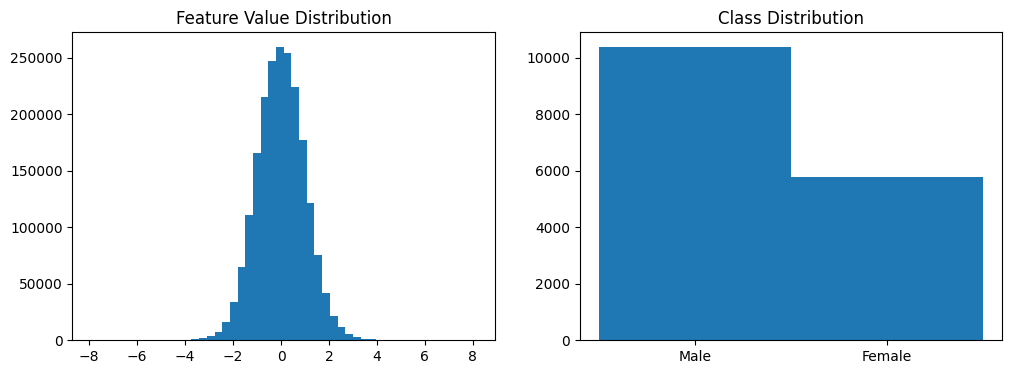

Graph info: 16148 nodes, 161480 edges

Testing simple model first...
Epoch 000: Loss=1.4160, Val Acc=0.7542
Epoch 010: Loss=0.0474, Val Acc=0.9960
Epoch 020: Loss=0.0242, Val Acc=0.9975
Epoch 030: Loss=0.0147, Val Acc=0.9988
Epoch 040: Loss=0.0134, Val Acc=0.9988
Epoch 050: Loss=0.0127, Val Acc=0.9988
Epoch 060: Loss=0.0093, Val Acc=0.9988
Epoch 070: Loss=0.0109, Val Acc=0.9988
Epoch 080: Loss=0.0085, Val Acc=0.9988
Epoch 090: Loss=0.0077, Val Acc=0.9988
Epoch 100: Loss=0.0065, Val Acc=0.9988
Epoch 110: Loss=0.0081, Val Acc=0.9988
Epoch 120: Loss=0.0071, Val Acc=0.9988
Epoch 130: Loss=0.0065, Val Acc=0.9988
Epoch 140: Loss=0.0057, Val Acc=0.9985
Epoch 150: Loss=0.0058, Val Acc=0.9985
Epoch 160: Loss=0.0054, Val Acc=0.9985
Epoch 170: Loss=0.0045, Val Acc=0.9985
Epoch 180: Loss=0.0053, Val Acc=0.9988
Epoch 190: Loss=0.0044, Val Acc=0.9985


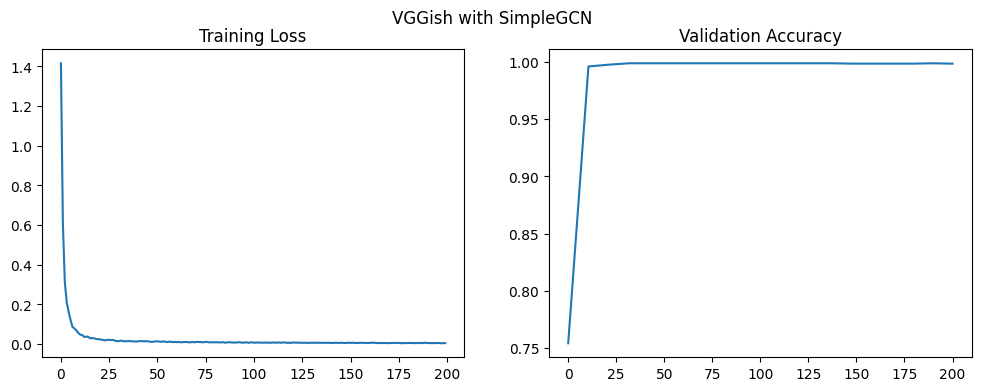

Simple model accuracy: 0.9985

Training GCN with VGGish features
Epoch 000: Loss=0.7202, Val Acc=0.9554
Epoch 010: Loss=0.0140, Val Acc=0.9988
Epoch 020: Loss=0.0100, Val Acc=0.9988
Epoch 030: Loss=0.0078, Val Acc=0.9994
Epoch 040: Loss=0.0072, Val Acc=0.9994
Epoch 050: Loss=0.0053, Val Acc=0.9994
Epoch 060: Loss=0.0056, Val Acc=0.9994
Epoch 070: Loss=0.0056, Val Acc=0.9991
Epoch 080: Loss=0.0041, Val Acc=0.9994
Epoch 090: Loss=0.0042, Val Acc=0.9994
Epoch 100: Loss=0.0039, Val Acc=0.9994
Epoch 110: Loss=0.0035, Val Acc=0.9994
Epoch 120: Loss=0.0041, Val Acc=0.9994
Epoch 130: Loss=0.0035, Val Acc=0.9994
Epoch 140: Loss=0.0032, Val Acc=0.9994
Epoch 150: Loss=0.0032, Val Acc=0.9994
Epoch 160: Loss=0.0030, Val Acc=0.9994
Epoch 170: Loss=0.0030, Val Acc=0.9994
Epoch 180: Loss=0.0029, Val Acc=0.9994
Epoch 190: Loss=0.0026, Val Acc=0.9994


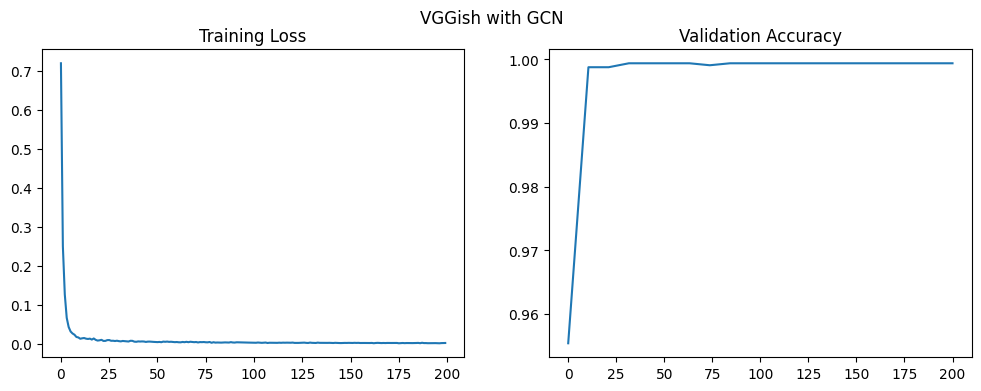

GCN with VGGish: Test Acc = 0.9994

Training GAT with VGGish features
Epoch 000: Loss=0.8447, Val Acc=0.9663
Epoch 010: Loss=0.1088, Val Acc=0.9991
Epoch 020: Loss=0.0789, Val Acc=0.9988
Epoch 030: Loss=0.0725, Val Acc=0.9988
Epoch 040: Loss=0.0645, Val Acc=0.9994
Epoch 050: Loss=0.0594, Val Acc=0.9997
Epoch 060: Loss=0.0608, Val Acc=0.9997
Epoch 070: Loss=0.0592, Val Acc=0.9997
Epoch 080: Loss=0.0599, Val Acc=0.9997
Epoch 090: Loss=0.0564, Val Acc=0.9997
Epoch 100: Loss=0.0558, Val Acc=0.9997
Epoch 110: Loss=0.0588, Val Acc=0.9997
Epoch 120: Loss=0.0575, Val Acc=0.9997
Epoch 130: Loss=0.0542, Val Acc=0.9997
Epoch 140: Loss=0.0580, Val Acc=0.9997
Epoch 150: Loss=0.0576, Val Acc=0.9997
Epoch 160: Loss=0.0526, Val Acc=0.9997
Epoch 170: Loss=0.0563, Val Acc=0.9997
Epoch 180: Loss=0.0550, Val Acc=0.9997
Epoch 190: Loss=0.0568, Val Acc=0.9997


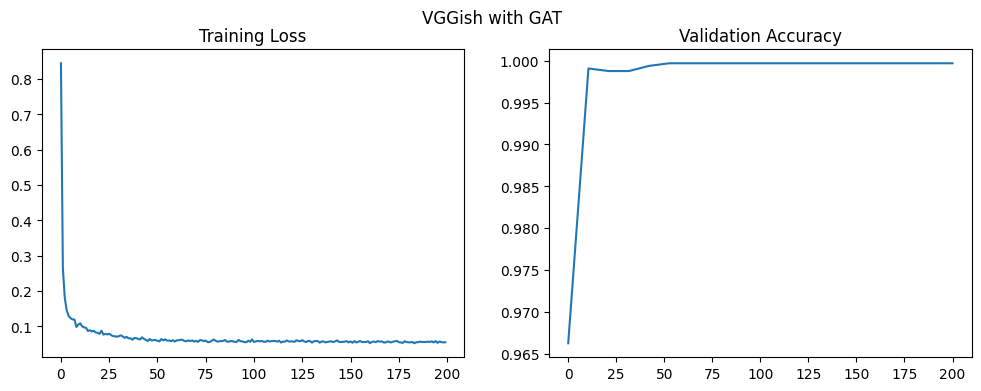

GAT with VGGish: Test Acc = 0.9997

Training GraphSAGE with VGGish features
Epoch 000: Loss=0.7067, Val Acc=0.9681
Epoch 010: Loss=0.0136, Val Acc=0.9981
Epoch 020: Loss=0.0101, Val Acc=0.9985
Epoch 030: Loss=0.0075, Val Acc=0.9985
Epoch 040: Loss=0.0038, Val Acc=0.9991
Epoch 050: Loss=0.0024, Val Acc=0.9991
Epoch 060: Loss=0.0023, Val Acc=0.9991
Epoch 070: Loss=0.0017, Val Acc=0.9985
Epoch 080: Loss=0.0019, Val Acc=0.9988
Epoch 090: Loss=0.0016, Val Acc=0.9985
Epoch 100: Loss=0.0018, Val Acc=0.9991
Epoch 110: Loss=0.0015, Val Acc=0.9985
Epoch 120: Loss=0.0013, Val Acc=0.9991
Epoch 130: Loss=0.0010, Val Acc=0.9991
Epoch 140: Loss=0.0010, Val Acc=0.9985
Epoch 150: Loss=0.0012, Val Acc=0.9985
Epoch 160: Loss=0.0009, Val Acc=0.9985
Epoch 170: Loss=0.0009, Val Acc=0.9991
Epoch 180: Loss=0.0009, Val Acc=0.9991
Epoch 190: Loss=0.0010, Val Acc=0.9985


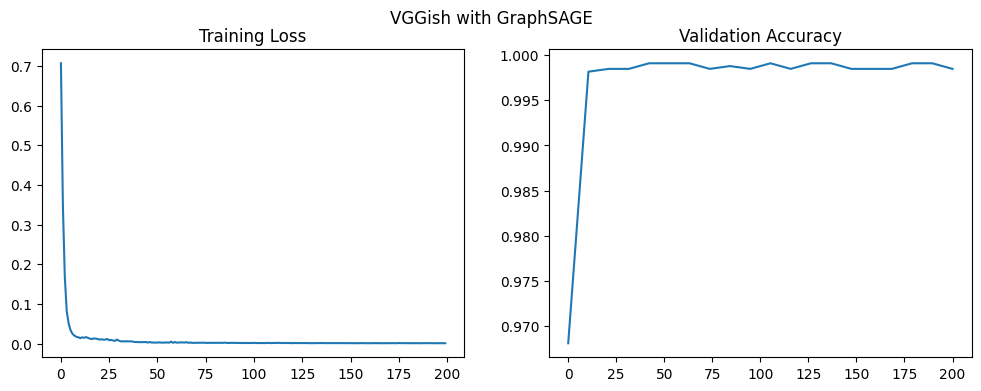

GraphSAGE with VGGish: Test Acc = 0.9991


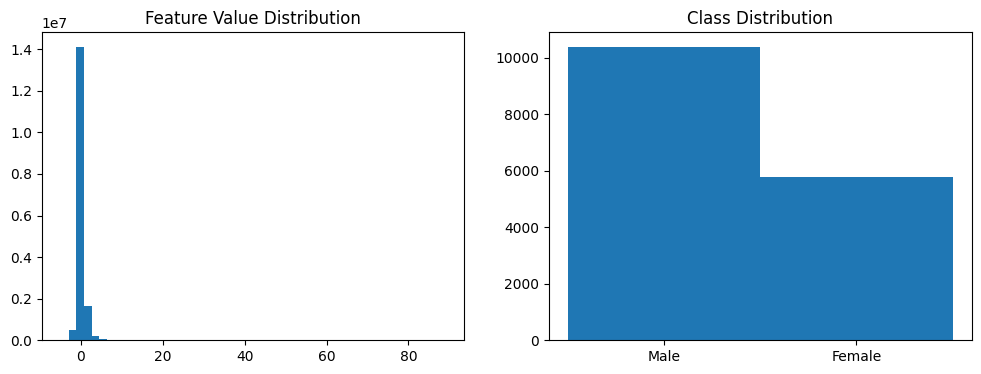

Graph info: 16148 nodes, 161480 edges

Testing simple model first...
Epoch 000: Loss=1.1983, Val Acc=0.8947
Epoch 010: Loss=0.2140, Val Acc=0.9573
Epoch 020: Loss=0.1288, Val Acc=0.9669
Epoch 030: Loss=0.1020, Val Acc=0.9703
Epoch 040: Loss=0.0834, Val Acc=0.9743
Epoch 050: Loss=0.0717, Val Acc=0.9743
Epoch 060: Loss=0.0671, Val Acc=0.9728
Epoch 070: Loss=0.0640, Val Acc=0.9762
Epoch 080: Loss=0.0578, Val Acc=0.9752
Epoch 090: Loss=0.0571, Val Acc=0.9749
Epoch 100: Loss=0.0528, Val Acc=0.9746
Epoch 110: Loss=0.0498, Val Acc=0.9759
Epoch 120: Loss=0.0500, Val Acc=0.9749
Epoch 130: Loss=0.0478, Val Acc=0.9755
Epoch 140: Loss=0.0456, Val Acc=0.9740
Epoch 150: Loss=0.0453, Val Acc=0.9749
Epoch 160: Loss=0.0442, Val Acc=0.9749
Epoch 170: Loss=0.0422, Val Acc=0.9755
Epoch 180: Loss=0.0424, Val Acc=0.9752
Epoch 190: Loss=0.0405, Val Acc=0.9759


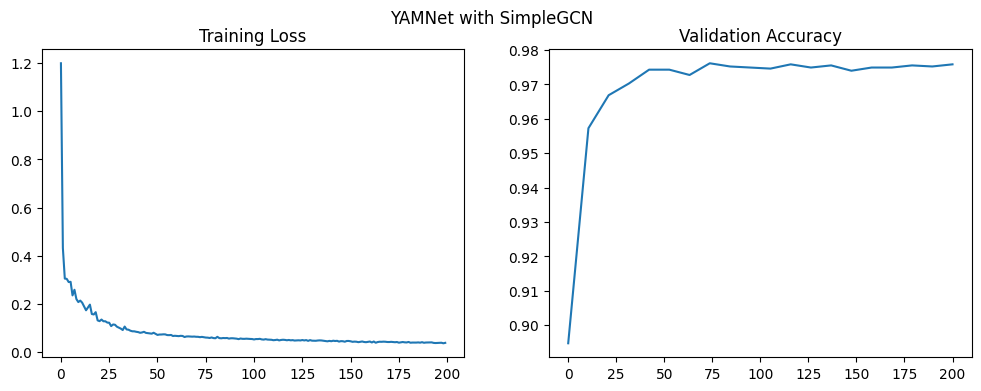

Simple model accuracy: 0.9749

Training GCN with YAMNet features
Epoch 000: Loss=1.1953, Val Acc=0.8548
Epoch 010: Loss=0.2509, Val Acc=0.9619
Epoch 020: Loss=0.1672, Val Acc=0.9737
Epoch 030: Loss=0.1112, Val Acc=0.9765
Epoch 040: Loss=0.0855, Val Acc=0.9771
Epoch 050: Loss=0.0716, Val Acc=0.9759
Epoch 060: Loss=0.0639, Val Acc=0.9771
Epoch 070: Loss=0.0636, Val Acc=0.9783
Epoch 080: Loss=0.0596, Val Acc=0.9786
Epoch 090: Loss=0.0550, Val Acc=0.9789
Epoch 100: Loss=0.0519, Val Acc=0.9793
Epoch 110: Loss=0.0480, Val Acc=0.9799
Epoch 120: Loss=0.0463, Val Acc=0.9789
Epoch 130: Loss=0.0459, Val Acc=0.9786
Epoch 140: Loss=0.0441, Val Acc=0.9786
Epoch 150: Loss=0.0422, Val Acc=0.9780
Epoch 160: Loss=0.0399, Val Acc=0.9783
Epoch 170: Loss=0.0374, Val Acc=0.9780
Epoch 180: Loss=0.0370, Val Acc=0.9786
Epoch 190: Loss=0.0354, Val Acc=0.9796


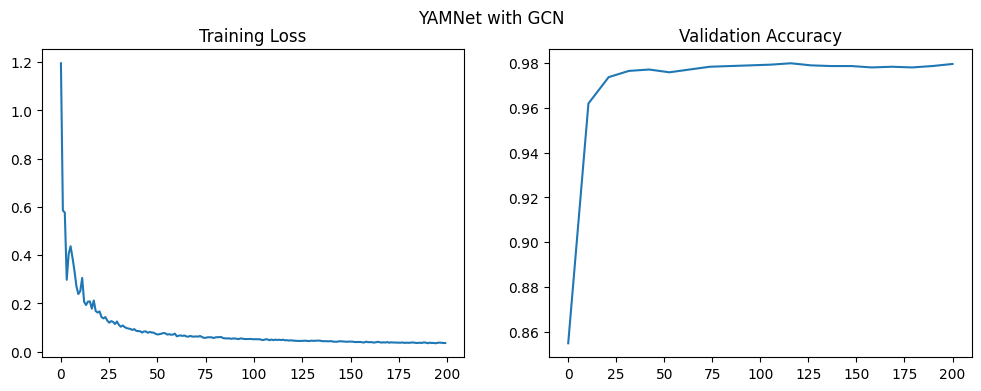

GCN with YAMNet: Test Acc = 0.9793

Training GAT with YAMNet features
Epoch 000: Loss=1.1725, Val Acc=0.7703
Epoch 010: Loss=0.6804, Val Acc=0.9337
Epoch 020: Loss=0.5658, Val Acc=0.9344
Epoch 030: Loss=0.4968, Val Acc=0.9492
Epoch 040: Loss=0.4087, Val Acc=0.9613
Epoch 050: Loss=0.3090, Val Acc=0.9718
Epoch 060: Loss=0.2438, Val Acc=0.9712
Epoch 070: Loss=0.1887, Val Acc=0.9743
Epoch 080: Loss=0.1737, Val Acc=0.9762
Epoch 090: Loss=0.1705, Val Acc=0.9768
Epoch 100: Loss=0.1665, Val Acc=0.9768
Epoch 110: Loss=0.1559, Val Acc=0.9783
Epoch 120: Loss=0.1587, Val Acc=0.9780
Epoch 130: Loss=0.1495, Val Acc=0.9808
Epoch 140: Loss=0.1452, Val Acc=0.9808
Epoch 150: Loss=0.1562, Val Acc=0.9802
Epoch 160: Loss=0.1621, Val Acc=0.9783
Epoch 170: Loss=0.1440, Val Acc=0.9783
Epoch 180: Loss=0.1424, Val Acc=0.9799
Epoch 190: Loss=0.1428, Val Acc=0.9802


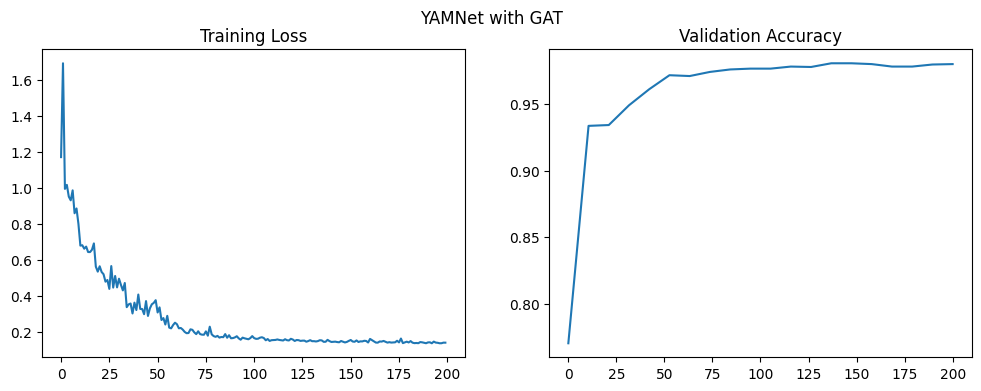

GAT with YAMNet: Test Acc = 0.9805

Training GraphSAGE with YAMNet features
Epoch 000: Loss=0.7280, Val Acc=0.9028
Epoch 010: Loss=0.0954, Val Acc=0.9774
Epoch 020: Loss=0.0562, Val Acc=0.9808
Epoch 030: Loss=0.0356, Val Acc=0.9839
Epoch 040: Loss=0.0292, Val Acc=0.9873
Epoch 050: Loss=0.0192, Val Acc=0.9879
Epoch 060: Loss=0.0163, Val Acc=0.9895
Epoch 070: Loss=0.0110, Val Acc=0.9901
Epoch 080: Loss=0.0112, Val Acc=0.9895
Epoch 090: Loss=0.0098, Val Acc=0.9913
Epoch 100: Loss=0.0078, Val Acc=0.9898
Epoch 110: Loss=0.0251, Val Acc=0.9913
Epoch 120: Loss=0.0126, Val Acc=0.9907
Epoch 130: Loss=0.0095, Val Acc=0.9907
Epoch 140: Loss=0.0088, Val Acc=0.9923
Epoch 150: Loss=0.0074, Val Acc=0.9920
Epoch 160: Loss=0.0101, Val Acc=0.9904
Epoch 170: Loss=0.0088, Val Acc=0.9907
Epoch 180: Loss=0.0088, Val Acc=0.9910
Epoch 190: Loss=0.0075, Val Acc=0.9910


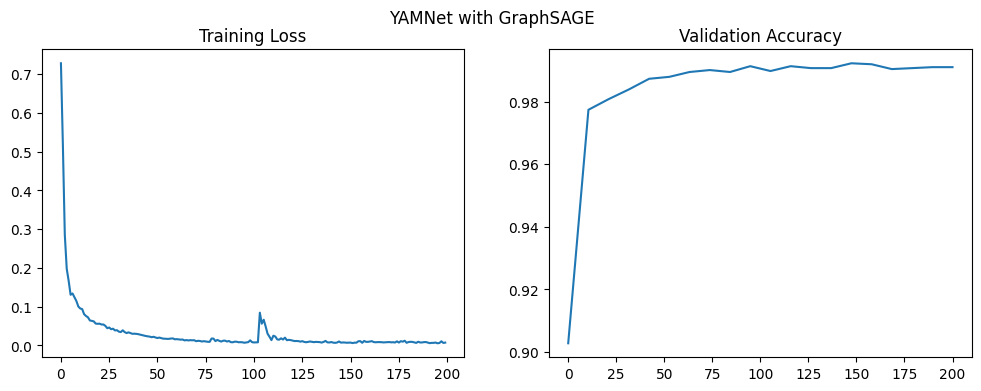

GraphSAGE with YAMNet: Test Acc = 0.9926


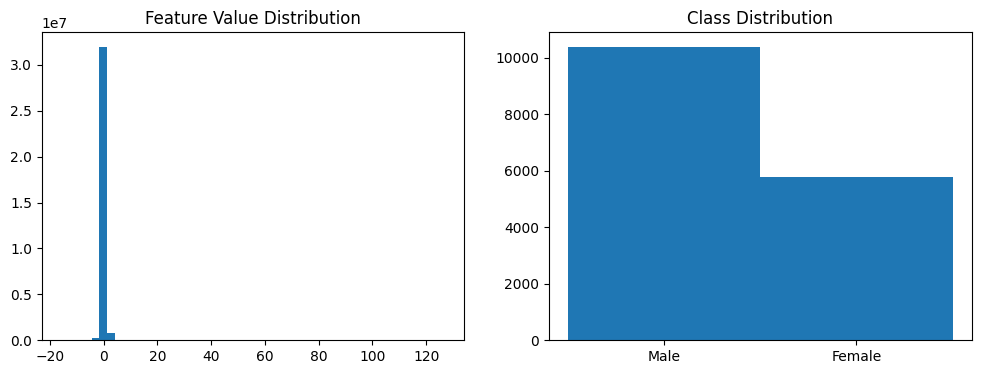

Graph info: 16148 nodes, 161480 edges

Testing simple model first...
Epoch 000: Loss=1.0280, Val Acc=0.9251
Epoch 010: Loss=0.1137, Val Acc=0.9746
Epoch 020: Loss=0.0872, Val Acc=0.9762
Epoch 030: Loss=0.0771, Val Acc=0.9771
Epoch 040: Loss=0.0661, Val Acc=0.9780
Epoch 050: Loss=0.0597, Val Acc=0.9786
Epoch 060: Loss=0.0575, Val Acc=0.9793
Epoch 070: Loss=0.0521, Val Acc=0.9796
Epoch 080: Loss=0.0496, Val Acc=0.9793
Epoch 090: Loss=0.0480, Val Acc=0.9793
Epoch 100: Loss=0.0486, Val Acc=0.9802
Epoch 110: Loss=0.0464, Val Acc=0.9808
Epoch 120: Loss=0.0462, Val Acc=0.9802
Epoch 130: Loss=0.0443, Val Acc=0.9805
Epoch 140: Loss=0.0444, Val Acc=0.9796
Epoch 150: Loss=0.0427, Val Acc=0.9799
Epoch 160: Loss=0.0427, Val Acc=0.9799
Epoch 170: Loss=0.0406, Val Acc=0.9805
Epoch 180: Loss=0.0407, Val Acc=0.9793
Epoch 190: Loss=0.0413, Val Acc=0.9793


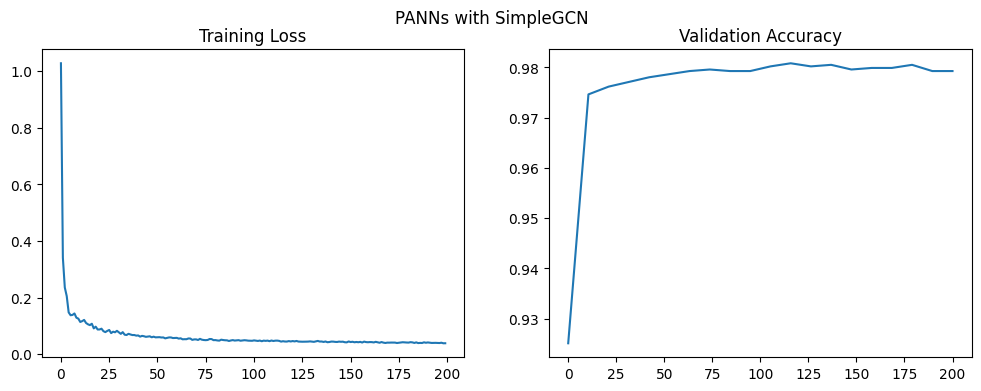

Simple model accuracy: 0.9796

Training GCN with PANNs features
Epoch 000: Loss=1.2278, Val Acc=0.9548
Epoch 010: Loss=0.1726, Val Acc=0.9715
Epoch 020: Loss=0.1074, Val Acc=0.9718
Epoch 030: Loss=0.0781, Val Acc=0.9728
Epoch 040: Loss=0.0660, Val Acc=0.9740
Epoch 050: Loss=0.0620, Val Acc=0.9728
Epoch 060: Loss=0.0544, Val Acc=0.9752
Epoch 070: Loss=0.0492, Val Acc=0.9749
Epoch 080: Loss=0.0479, Val Acc=0.9740
Epoch 090: Loss=0.0484, Val Acc=0.9743
Epoch 100: Loss=0.0448, Val Acc=0.9752
Epoch 110: Loss=0.0421, Val Acc=0.9740
Epoch 120: Loss=0.0406, Val Acc=0.9740
Epoch 130: Loss=0.0399, Val Acc=0.9752
Epoch 140: Loss=0.0388, Val Acc=0.9755
Epoch 150: Loss=0.0388, Val Acc=0.9737
Epoch 160: Loss=0.0375, Val Acc=0.9734
Epoch 170: Loss=0.0395, Val Acc=0.9731
Epoch 180: Loss=0.0367, Val Acc=0.9731
Epoch 190: Loss=0.0367, Val Acc=0.9740


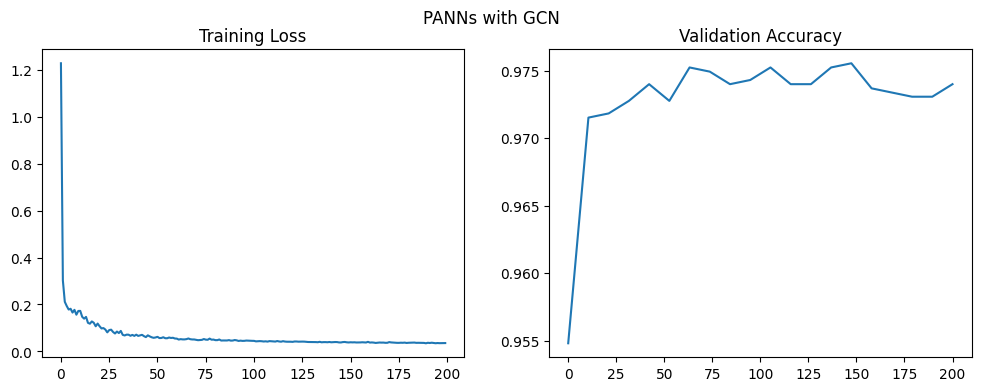

GCN with PANNs: Test Acc = 0.9734

Training GAT with PANNs features
Epoch 000: Loss=2.9601, Val Acc=0.9322
Epoch 010: Loss=0.4861, Val Acc=0.9653
Epoch 020: Loss=0.3530, Val Acc=0.9591
Epoch 030: Loss=0.2667, Val Acc=0.9647
Epoch 040: Loss=0.2045, Val Acc=0.9693
Epoch 050: Loss=0.1702, Val Acc=0.9737
Epoch 060: Loss=0.1395, Val Acc=0.9762
Epoch 070: Loss=0.1420, Val Acc=0.9786
Epoch 080: Loss=0.1186, Val Acc=0.9796
Epoch 090: Loss=0.1132, Val Acc=0.9805
Epoch 100: Loss=0.1059, Val Acc=0.9824
Epoch 110: Loss=0.1097, Val Acc=0.9827
Epoch 120: Loss=0.1031, Val Acc=0.9830
Epoch 130: Loss=0.1031, Val Acc=0.9820
Epoch 140: Loss=0.0993, Val Acc=0.9824
Epoch 150: Loss=0.0987, Val Acc=0.9820
Epoch 160: Loss=0.0991, Val Acc=0.9820
Epoch 170: Loss=0.0965, Val Acc=0.9824
Epoch 180: Loss=0.0955, Val Acc=0.9830
Epoch 190: Loss=0.0953, Val Acc=0.9830


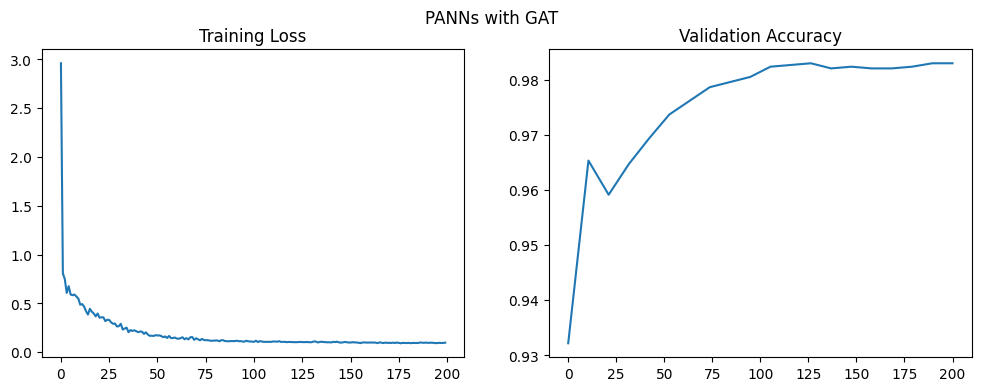

GAT with PANNs: Test Acc = 0.9824

Training GraphSAGE with PANNs features
Epoch 000: Loss=0.7139, Val Acc=0.9480
Epoch 010: Loss=0.0670, Val Acc=0.9845
Epoch 020: Loss=0.0345, Val Acc=0.9876
Epoch 030: Loss=0.0252, Val Acc=0.9867
Epoch 040: Loss=0.0202, Val Acc=0.9892
Epoch 050: Loss=0.0154, Val Acc=0.9898
Epoch 060: Loss=0.0129, Val Acc=0.9910
Epoch 070: Loss=0.0089, Val Acc=0.9920
Epoch 080: Loss=0.0066, Val Acc=0.9916
Epoch 090: Loss=0.0057, Val Acc=0.9926
Epoch 100: Loss=0.0037, Val Acc=0.9929
Epoch 110: Loss=0.0042, Val Acc=0.9926
Epoch 120: Loss=0.0057, Val Acc=0.9938
Epoch 130: Loss=0.0043, Val Acc=0.9938
Epoch 140: Loss=0.0040, Val Acc=0.9932
Epoch 150: Loss=0.0038, Val Acc=0.9935
Epoch 160: Loss=0.0047, Val Acc=0.9926
Epoch 170: Loss=0.0046, Val Acc=0.9944
Epoch 180: Loss=0.0041, Val Acc=0.9923
Epoch 190: Loss=0.0057, Val Acc=0.9932


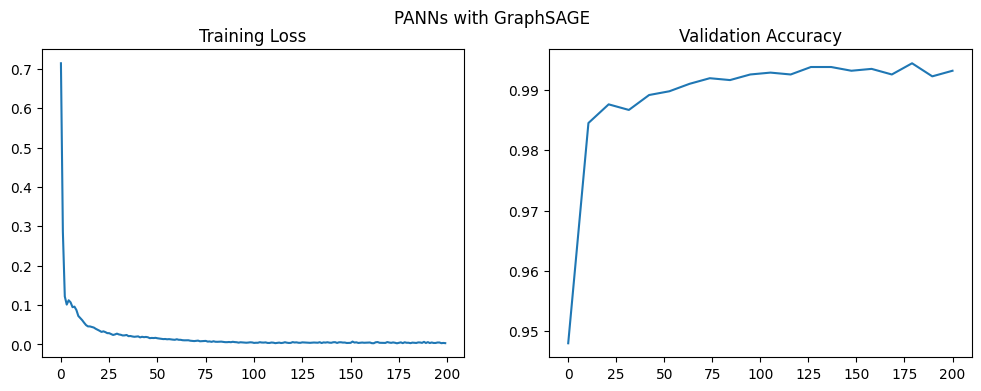

GraphSAGE with PANNs: Test Acc = 0.9923

=== Final Results ===
VGGish_GCN: 0.9994
VGGish_GAT: 0.9997
VGGish_GraphSAGE: 0.9991
YAMNet_GCN: 0.9793
YAMNet_GAT: 0.9805
YAMNet_GraphSAGE: 0.9926
PANNs_GCN: 0.9734
PANNs_GAT: 0.9824
PANNs_GraphSAGE: 0.9923


In [17]:
# ==========================================
# STEP 7: Graph Construction, GNN Architectures and Training
# ==========================================

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Fix random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# 1. Load and prepare data
def load_and_prepare_data():
    features = {
        'VGGish': np.load('./audio_features/vggish_features.npy'),
        'YAMNet': np.load('./audio_features/yamnet_features.npy'),
        'PANNs': np.load('./audio_features/panns_features.npy')
    }

    metadata = pd.read_csv('./audio_features/file_metadata.csv')

    # Using the existing gender columns
    valid_mask = metadata['gender'].isin(['male', 'female'])
    labels = metadata.loc[valid_mask, 'gender'].map({'male': 0, 'female': 1}).values

    for model in features:
        features[model] = features[model][valid_mask]

    print(f"Valid samples: {len(labels)} (Male: {sum(labels==0)}, Female: {sum(labels==1)})")
    return features, labels



# 2. Graph construction
def build_graph(features, labels, k=10, plot_dist=False):
    """Build graph with debugging features"""
    # Standardize features
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    # Build k-NN graph
    adj_matrix = kneighbors_graph(features, n_neighbors=k, mode='connectivity', include_self=False)

    # Convert to edge index
    row, col = adj_matrix.nonzero()
    edge_index = torch.tensor(np.vstack([row, col]), dtype=torch.long)

    # Create graph data object
    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)

    # Plot feature distribution
    if plot_dist:
        plt.figure(figsize=(12, 4))
        plt.subplot(121)
        plt.hist(features.ravel(), bins=50)
        plt.title("Feature Value Distribution")
        plt.subplot(122)
        plt.hist(labels, bins=[-0.5, 0.5, 1.5])
        plt.xticks([0, 1], ['Male', 'Female'])
        plt.title("Class Distribution")
        plt.show()

    print(f"Graph info: {x.shape[0]} nodes, {edge_index.shape[1]} edges")
    return Data(x=x, edge_index=edge_index, y=y)

# 3. GNN Models: GCN
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.dropout = 0.5

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)


# 4. GNN Models: GAT
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.5)
        self.conv2 = GATConv(hidden_channels*heads, out_channels, heads=1, concat=False, dropout=0.5)
        self.dropout = 0.5

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# 5. GNN Models: GraphSAGE
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, out_channels)
        self.dropout = 0.5

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)


# 6. Training with masking and debugging
def train_and_evaluate(model, data, model_name, feature_name):
    # Create train/test masks
    idx = np.arange(data.num_nodes)
    # Moveing data.y to CPU and convert to numpy
    train_idx, test_idx = train_test_split(idx, test_size=0.2, stratify=data.y.cpu().numpy())

    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.train_mask[train_idx] = True
    data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.test_mask[test_idx] = True

    # Model setup
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
    criterion = torch.nn.NLLLoss()

    # Training loop
    train_losses, val_accs = [], []
    for epoch in range(200):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                _, pred = model(data).max(dim=1)
                correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
                acc = correct / data.test_mask.sum().item()
                val_accs.append(acc)
                print(f'Epoch {epoch:03d}: Loss={loss:.4f}, Val Acc={acc:.4f}')

    # Final evaluation
    model.eval()
    _, pred = model(data).max(dim=1)
    test_acc = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(train_losses)
    plt.title("Training Loss")
    plt.subplot(122)
    plt.plot(np.linspace(0, 200, len(val_accs)), val_accs)
    plt.title("Validation Accuracy")
    plt.suptitle(f"{feature_name} with {model_name}")
    plt.show()

    return test_acc

# 7. Main execution flow
def main():
    # Load data
    features, labels = load_and_prepare_data()

    results = {}
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    for feature_name, feature_array in features.items():
        # Build graph with visualization
        graph_data = build_graph(feature_array, labels, k=10, plot_dist=True)
        graph_data = graph_data.to(device)

        # Test simple model first
        print("\nTesting simple model first...")
        test_model = GCN(graph_data.num_node_features, 32, 2).to(device)
        test_acc = train_and_evaluate(test_model, graph_data, "SimpleGCN", feature_name)
        print(f"Simple model accuracy: {test_acc:.4f}")

        # Test full models
        models = {
            'GCN': GCN(graph_data.num_node_features, 64, 2).to(device),
            'GAT': GAT(graph_data.num_node_features, 32, 2, heads=4).to(device),
            'GraphSAGE': GraphSAGE(graph_data.num_node_features, 64, 2).to(device)
        }

        for model_name, model in models.items():
            print(f"\nTraining {model_name} with {feature_name} features")
            acc = train_and_evaluate(model, graph_data, model_name, feature_name)
            results[f"{feature_name}_{model_name}"] = acc
            print(f"{model_name} with {feature_name}: Test Acc = {acc:.4f}")

    # Print final results
    print("\n=== Final Results ===")
    for model_name, acc in results.items():
        print(f"{model_name}: {acc:.4f}")

    return results


if __name__ == "__main__":
    main()

Valid samples: 16148 (Male: 10380, Female: 5768)
Using device: cuda
Graph info: 16148 nodes, 161480 edges

Training and Evaluating GCN with VGGish features


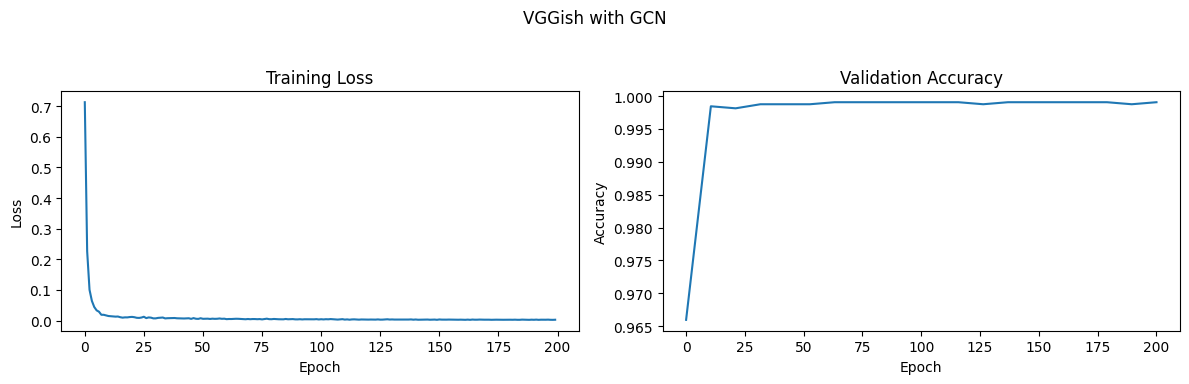

--- GCN with VGGish Metrics ---
Accuracy: 0.9991
Precision: 0.9991
Recall: 0.9991
F1-Score: 0.9991
Training Time: 1.90 seconds
-------------------------------

Training and Evaluating GAT with VGGish features


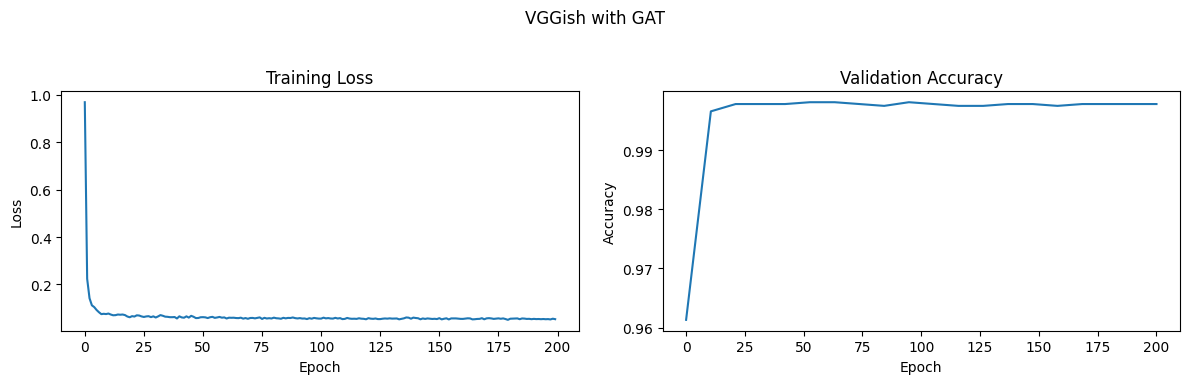

--- GAT with VGGish Metrics ---
Accuracy: 0.9975
Precision: 0.9975
Recall: 0.9975
F1-Score: 0.9975
Training Time: 2.76 seconds
-------------------------------

Training and Evaluating GraphSAGE with VGGish features


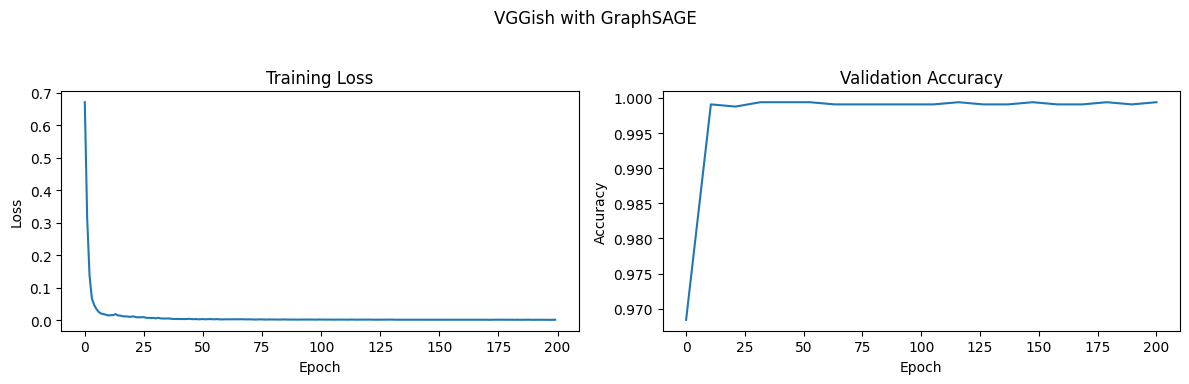

--- GraphSAGE with VGGish Metrics ---
Accuracy: 0.9991
Precision: 0.9991
Recall: 0.9991
F1-Score: 0.9991
Training Time: 1.65 seconds
-------------------------------------
Graph info: 16148 nodes, 161480 edges

Training and Evaluating GCN with YAMNet features


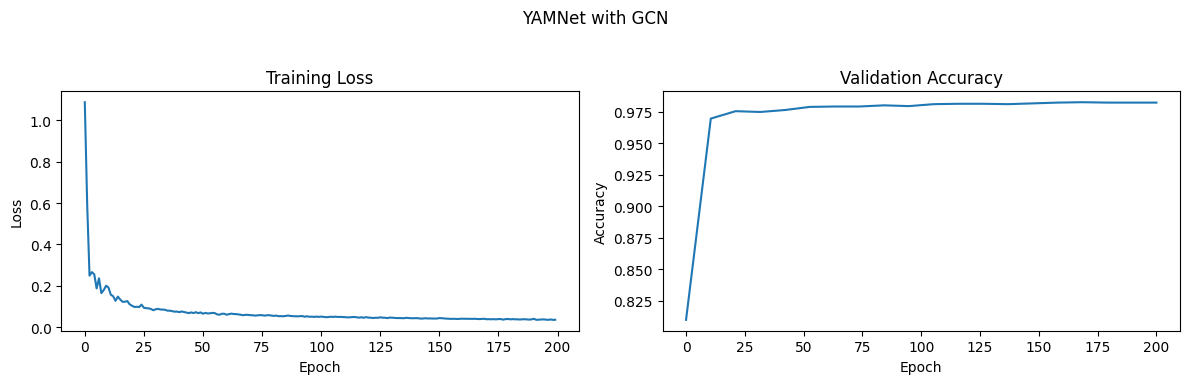

--- GCN with YAMNet Metrics ---
Accuracy: 0.9817
Precision: 0.9817
Recall: 0.9817
F1-Score: 0.9817
Training Time: 2.32 seconds
-------------------------------

Training and Evaluating GAT with YAMNet features


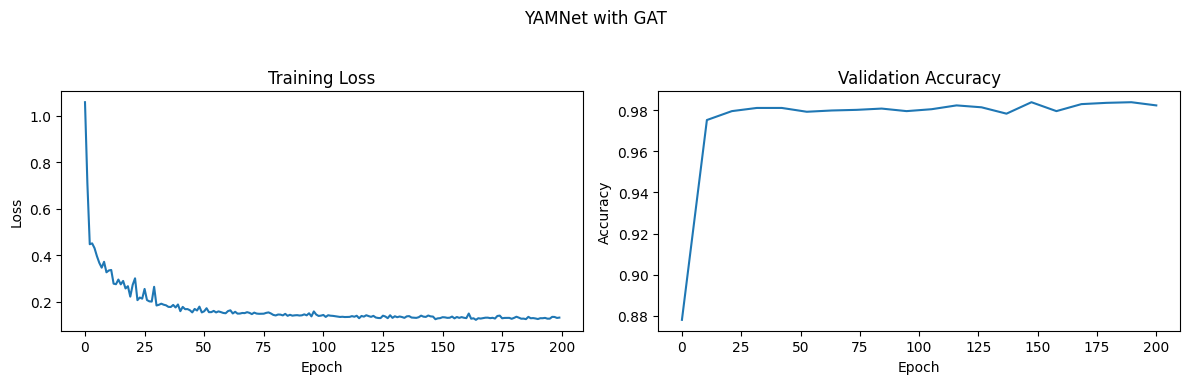

--- GAT with YAMNet Metrics ---
Accuracy: 0.9839
Precision: 0.9840
Recall: 0.9839
F1-Score: 0.9839
Training Time: 3.10 seconds
-------------------------------

Training and Evaluating GraphSAGE with YAMNet features


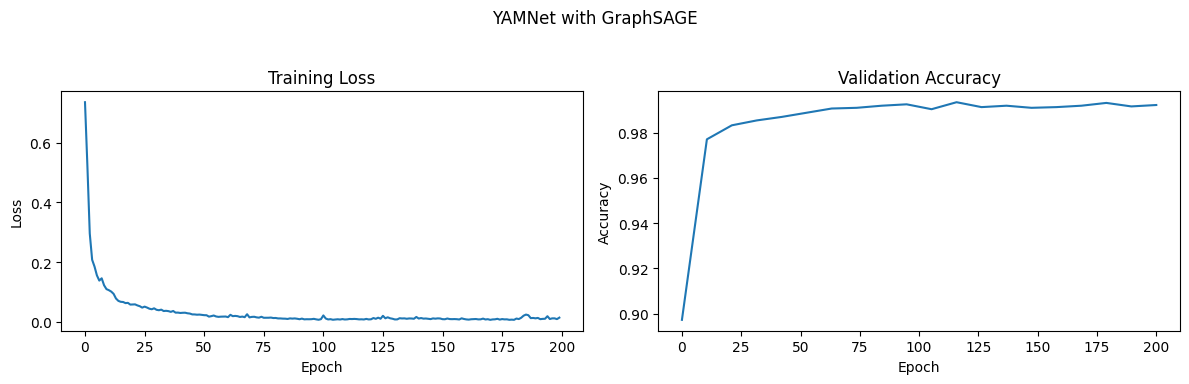

--- GraphSAGE with YAMNet Metrics ---
Accuracy: 0.9935
Precision: 0.9935
Recall: 0.9935
F1-Score: 0.9935
Training Time: 5.22 seconds
-------------------------------------
Graph info: 16148 nodes, 161480 edges

Training and Evaluating GCN with PANNs features


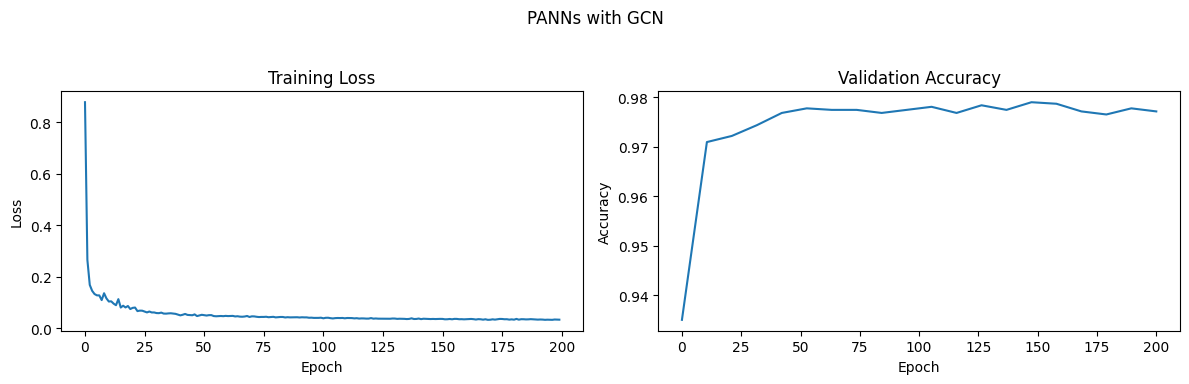

--- GCN with PANNs Metrics ---
Accuracy: 0.9777
Precision: 0.9777
Recall: 0.9777
F1-Score: 0.9777
Training Time: 2.55 seconds
------------------------------

Training and Evaluating GAT with PANNs features


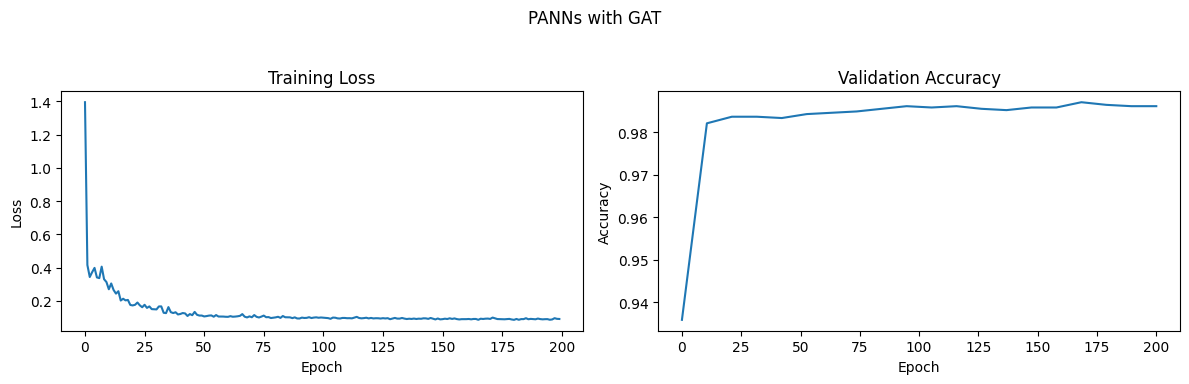

--- GAT with PANNs Metrics ---
Accuracy: 0.9873
Precision: 0.9873
Recall: 0.9873
F1-Score: 0.9873
Training Time: 3.58 seconds
------------------------------

Training and Evaluating GraphSAGE with PANNs features


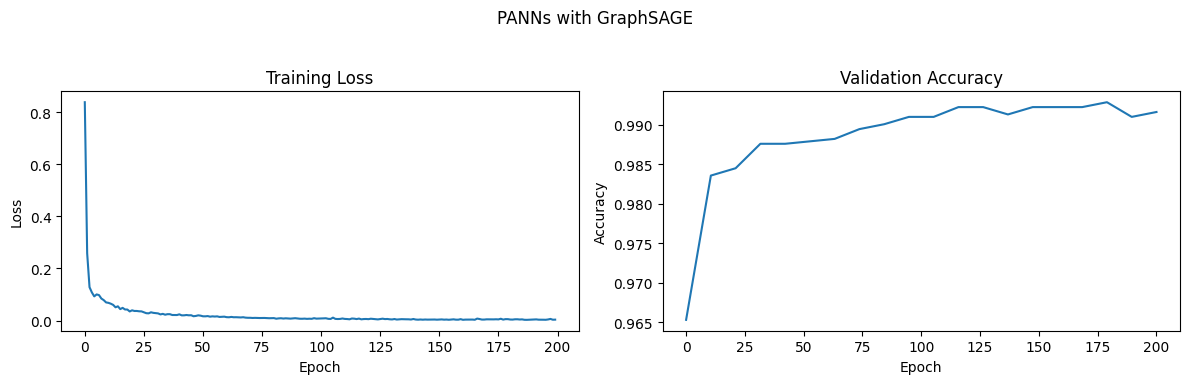

--- GraphSAGE with PANNs Metrics ---
Accuracy: 0.9920
Precision: 0.9919
Recall: 0.9920
F1-Score: 0.9919
Training Time: 9.36 seconds
------------------------------------

FINAL PERFORMANCE COMPARISON

Performance Metrics per Model and Feature:
|                  | accuracy   | precision   | recall   | f1_score   | training_time   |
|:-----------------|:-----------|:------------|:---------|:-----------|:----------------|
| VGGish_GCN       | 0.9991     | 0.9991      | 0.9991   | 0.9991     | 1.8993          |
| VGGish_GAT       | 0.9975     | 0.9975      | 0.9975   | 0.9975     | 2.7633          |
| VGGish_GraphSAGE | 0.9991     | 0.9991      | 0.9991   | 0.9991     | 1.6530          |
| YAMNet_GCN       | 0.9817     | 0.9817      | 0.9817   | 0.9817     | 2.3169          |
| YAMNet_GAT       | 0.9839     | 0.9840      | 0.9839   | 0.9839     | 3.1000          |
| YAMNet_GraphSAGE | 0.9935     | 0.9935      | 0.9935   | 0.9935     | 5.2208          |
| PANNs_GCN        | 0.9777     | 0.9

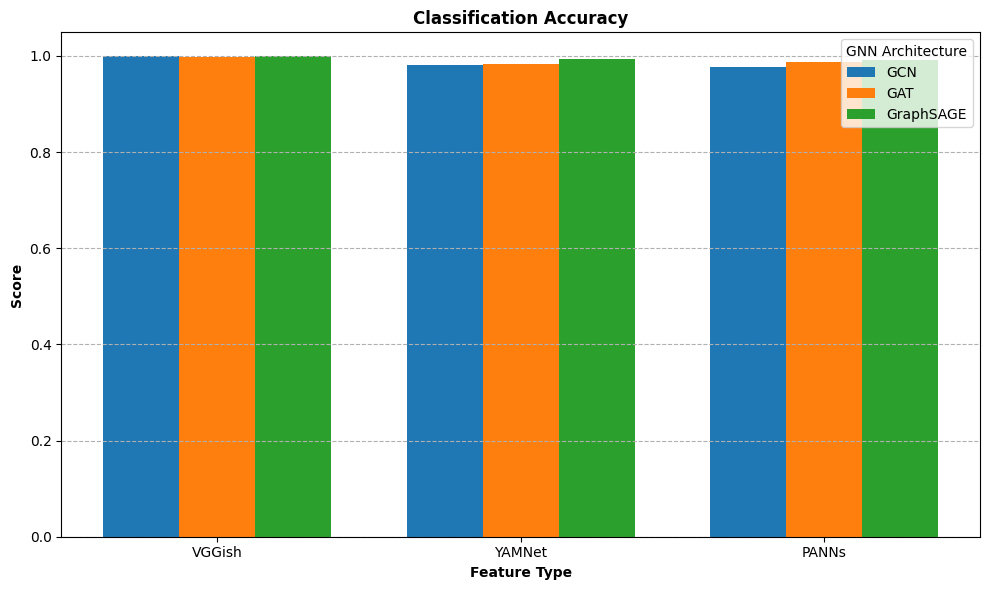

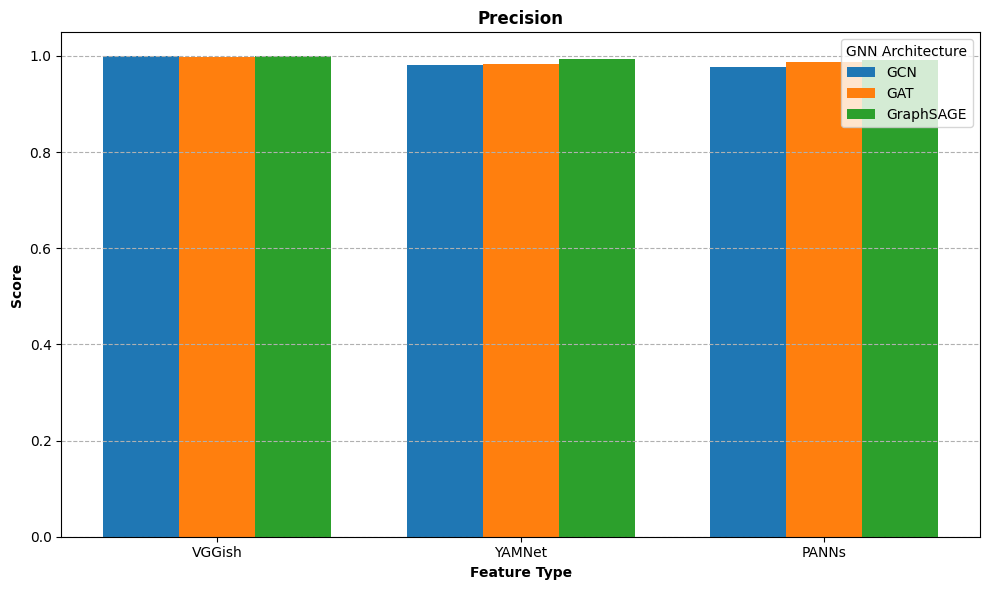

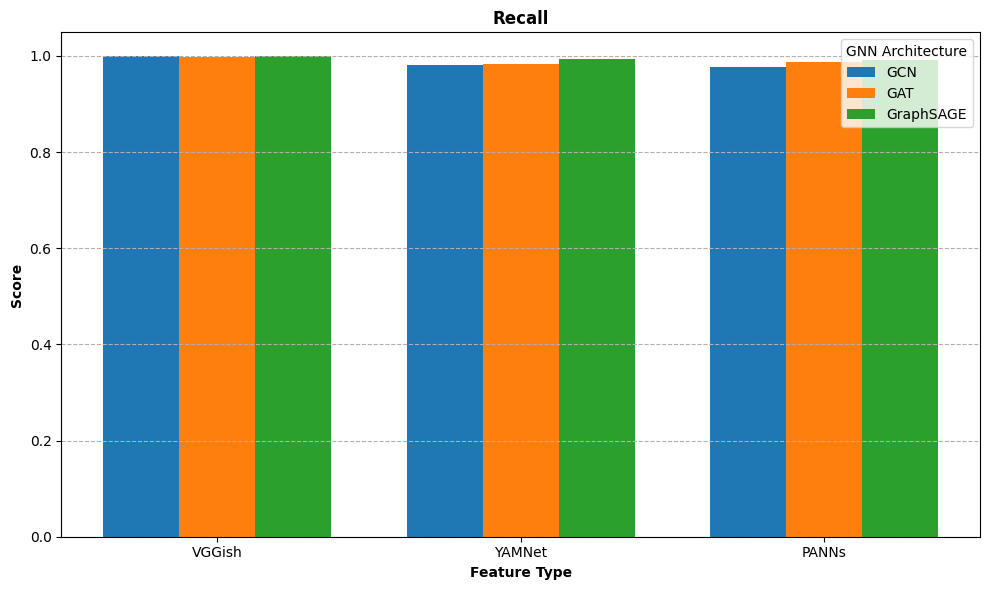

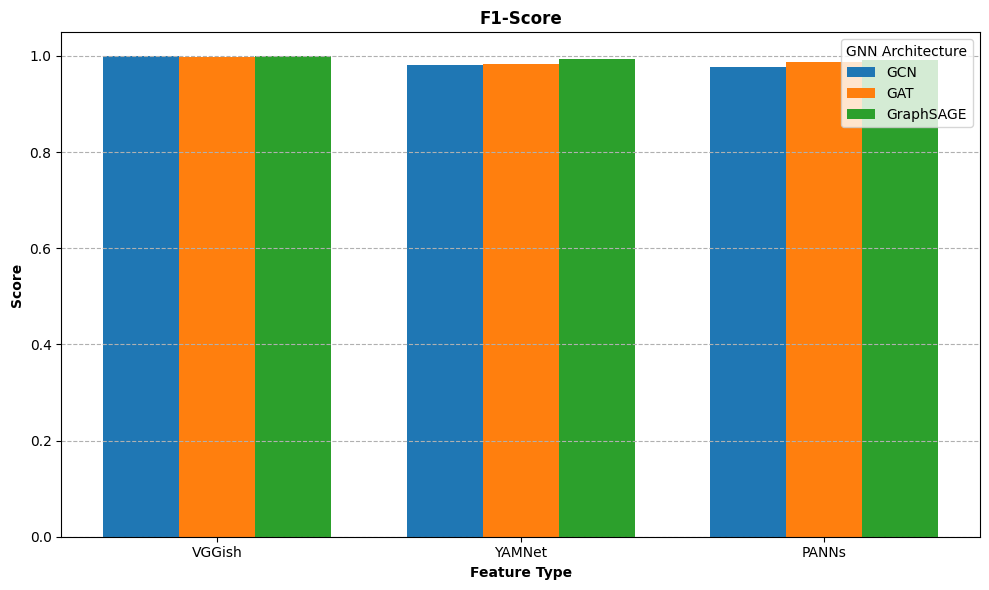

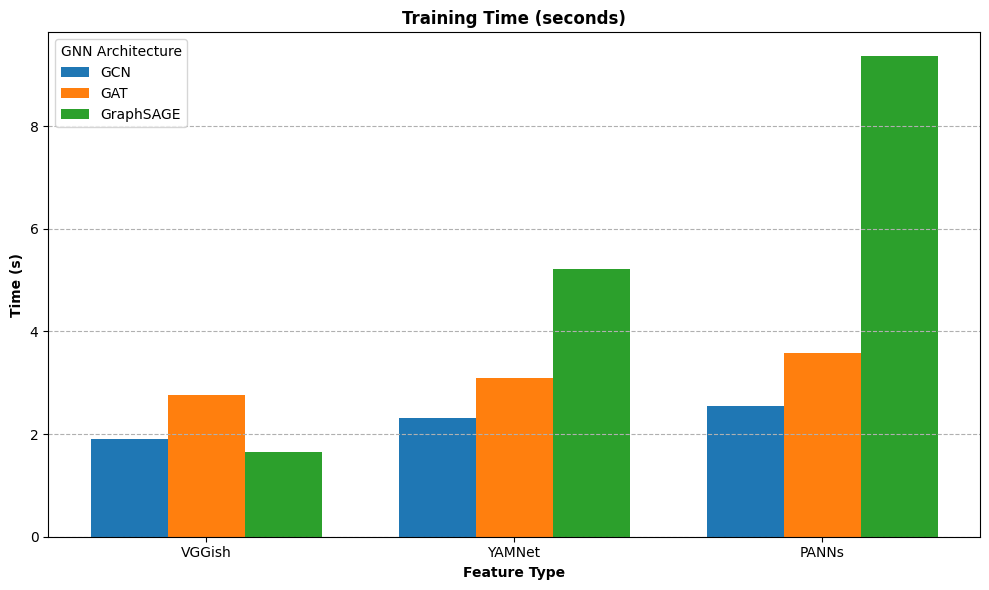

In [52]:
# ==========================================
# STEP 8: Training (again), but with all the metrics mentioned in the project setting.
# ==========================================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

# Training and evaluation with comprehensive metrics and timing
def train_and_evaluate(model, data, model_name, feature_name):
    # Create train/test masks
    idx = np.arange(data.num_nodes)
    train_idx, test_idx = train_test_split(idx, test_size=0.2, stratify=data.y.cpu().numpy())

    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.train_mask[train_idx] = True
    data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.test_mask[test_idx] = True

    # Model setup
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
    criterion = torch.nn.NLLLoss()

    # Training loop
    train_losses, val_accs = [], []
    start_time = time.time() # Start timing training
    for epoch in range(200):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                _, pred = model(data).max(dim=1)
                correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
                acc = correct / data.test_mask.sum().item()
                val_accs.append(acc)

    end_time = time.time() # End timing training
    training_time = end_time - start_time

    # Final evaluation
    model.eval()
    with torch.no_grad():
        logits = model(data)
        _, pred = logits.max(dim=1)

        # Calculate metrics
        y_true = data.y[data.test_mask].cpu().numpy()
        y_pred = pred[data.test_mask].cpu().numpy()

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)


    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(train_losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.subplot(122)
    plt.plot(np.linspace(0, 200, len(val_accs)), val_accs)
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.suptitle(f"{feature_name} with {model_name}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'training_time': training_time
    }

    print(f"--- {model_name} with {feature_name} Metrics ---")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-Score: {metrics['f1_score']:.4f}")
    print(f"Training Time: {metrics['training_time']:.2f} seconds")
    print("-" * (len(f"--- {model_name} with {feature_name} Metrics ---")))


    return metrics


# Main execution flow with metric collection and visualization
def main():
    # Load data
    features, labels = load_and_prepare_data()

    # Store results in a dictionary indexed by feature and model
    all_results = {}

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    for feature_name, feature_array in features.items():
        # Build graph with visualization
        graph_data = build_graph(feature_array, labels, k=10, plot_dist=False)
        graph_data = graph_data.to(device)



        # Test full models
        models_to_test = {
            'GCN': GCN(graph_data.num_node_features, 64, 2).to(device),
            'GAT': GAT(graph_data.num_node_features, 32, 2, heads=4).to(device),
            'GraphSAGE': GraphSAGE(graph_data.num_node_features, 64, 2).to(device)
        }

        for model_name, model in models_to_test.items():
            print(f"\nTraining and Evaluating {model_name} with {feature_name} features")
            metrics = train_and_evaluate(model, graph_data, model_name, feature_name)
            all_results[f"{feature_name}_{model_name}"] = metrics


    # Print and Visualize Final Results
    print("\n" + "="*50)
    print("FINAL PERFORMANCE COMPARISON")
    print("="*50)

    # Convert results to a pandas DataFrame
    results_df = pd.DataFrame(all_results).T # Transpose to have models/features as rows

    print("\nPerformance Metrics per Model and Feature:")
    print(results_df[['accuracy', 'precision', 'recall', 'f1_score', 'training_time']].to_markdown(numalign="left", stralign="left", floatfmt=".4f"))

    # Visualization
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score', 'training_time']
    titles = ['Classification Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (seconds)']
    ylabels = ['Score', 'Score', 'Score', 'Score', 'Time (s)']


    for i, metric in enumerate(metrics_to_plot):
        plt.figure(figsize=(10, 6))
        # Extract data for plotting
        metric_data = results_df[metric]

        # Separate by feature type for grouping
        feature_types = ['VGGish', 'YAMNet', 'PANNs']
        model_types = ['GCN', 'GAT', 'GraphSAGE']

        bar_width = 0.2
        r = np.arange(len(feature_types)) * (len(model_types) * bar_width + bar_width)
        for j, model_name in enumerate(model_types):
            model_values = [metric_data.get(f"{feature_type}_{model_name}", 0) for feature_type in feature_types]
            plt.bar(r + j * bar_width, model_values, width=bar_width, label=model_name)


        plt.xlabel("Feature Type", fontweight='bold')
        plt.ylabel(ylabels[i], fontweight='bold')
        plt.title(titles[i], fontweight='bold')
        plt.xticks(r + bar_width * (len(model_types) - 1) / 2, feature_types)
        plt.legend(title="GNN Architecture")
        plt.grid(axis='y', linestyle='--')
        plt.tight_layout()
        plt.show()

    return all_results


if __name__ == "__main__":
    final_comparison_results = main()


In [50]:
# ==========================================
# Step 9: BASELINE MODEL: Logistic Regression on All Feature Sets
# ==========================================

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

if 'features' not in locals() or 'metadata' not in locals():
    print("Error: Features or metadata not found. Please run the feature extraction steps first.")
else:
    print("Running Logistic Regression baseline model on all feature sets...")

    # Extract labels from the metadata DataFrame
    y = metadata['gender'].map({'male': 0, 'female': 1}).values

    baseline_results = {}

    for feature_name, feature_array in features.items():
        print(f"\n--- Training Baseline Model on {feature_name} Features ---")

        X = feature_array
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train logistic regression model
        clf = LogisticRegression(max_iter=200)
        clf.fit(X_train_scaled, y_train)
        print("Training complete.")

        # Evaluate
        print(f"\nEvaluating Baseline Model on {feature_name} Features:")
        y_pred = clf.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=['female', 'male'], output_dict=True)

        print(f"Baseline Model Accuracy ({feature_name}):", accuracy)
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['female', 'male']))

        # Store results with uppercase feature names for consistency
        baseline_results[feature_name.upper()] = {
            'accuracy': accuracy,
            'precision': report['weighted avg']['precision'],
            'recall': report['weighted avg']['recall'],
            'f1_score': report['weighted avg']['f1-score']
        }

    print("\n" + "="*50)
    print("BASELINE MODEL PERFORMANCE SUMMARY")
    print("="*50)

    baseline_results_df = pd.DataFrame.from_dict(baseline_results, orient='index')
    print(baseline_results_df.to_markdown(numalign="left", stralign="left", floatfmt=".4f"))

Running Logistic Regression baseline model on all feature sets...

--- Training Baseline Model on vggish Features ---
Training complete.

Evaluating Baseline Model on vggish Features:
Baseline Model Accuracy (vggish): 0.9991744066047472

Classification Report:
              precision    recall  f1-score   support

      female       1.00      1.00      1.00      3114
        male       1.00      1.00      1.00      1731

    accuracy                           1.00      4845
   macro avg       1.00      1.00      1.00      4845
weighted avg       1.00      1.00      1.00      4845


--- Training Baseline Model on yamnet Features ---
Training complete.

Evaluating Baseline Model on yamnet Features:
Baseline Model Accuracy (yamnet): 0.9917440660474717

Classification Report:
              precision    recall  f1-score   support

      female       0.99      0.99      0.99      3114
        male       0.99      0.99      0.99      1731

    accuracy                           0.99      4845

Visualizing features for each set using t-SNE...

Visualizing vggish features...
  PCA reduced to 50 components, retaining 0.9734 variance.


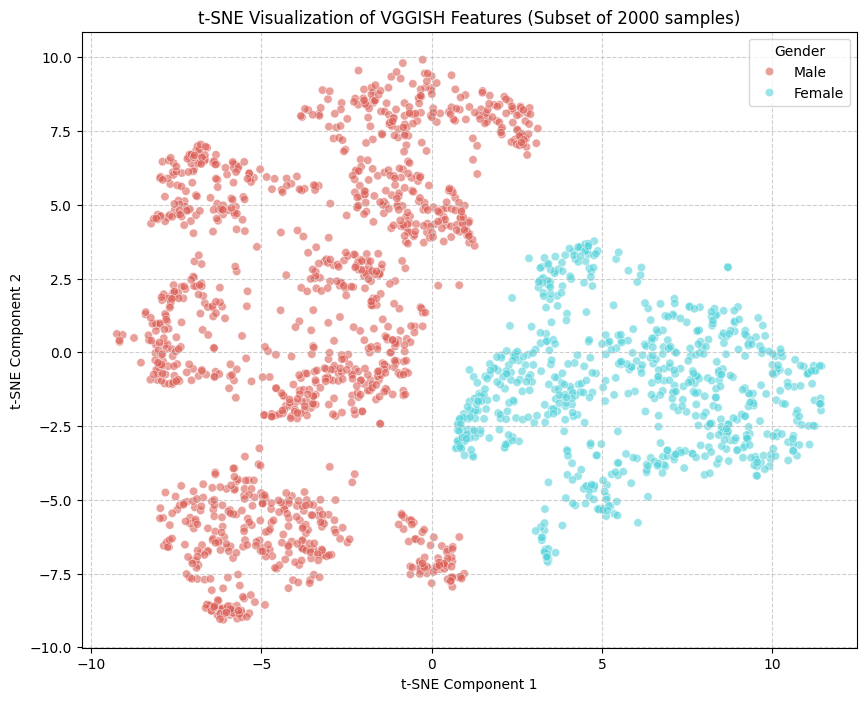


Visualizing yamnet features...
  PCA reduced to 50 components, retaining 0.9365 variance.


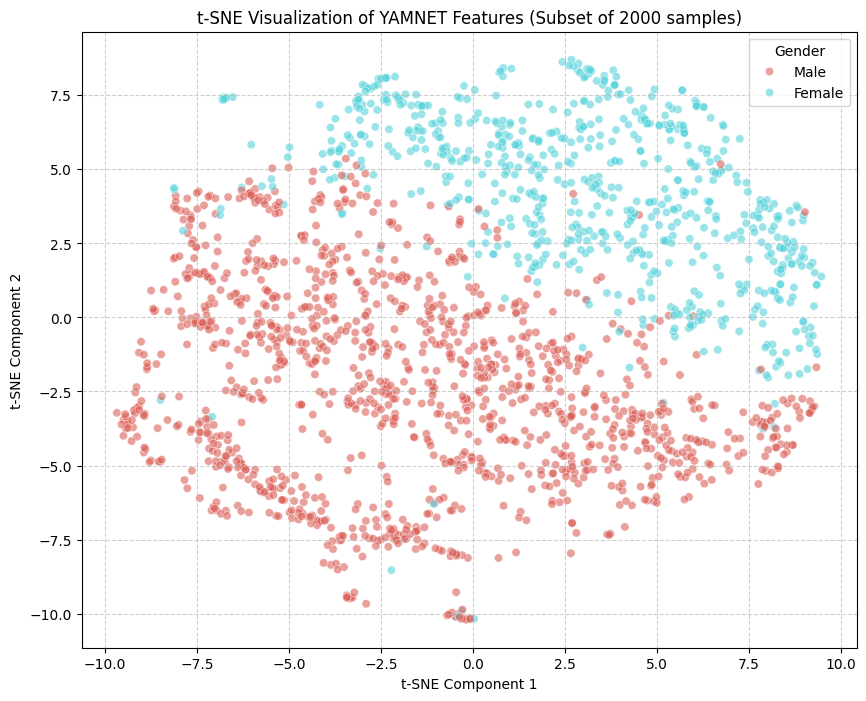


Visualizing panns features...
  PCA reduced to 50 components, retaining 0.9453 variance.


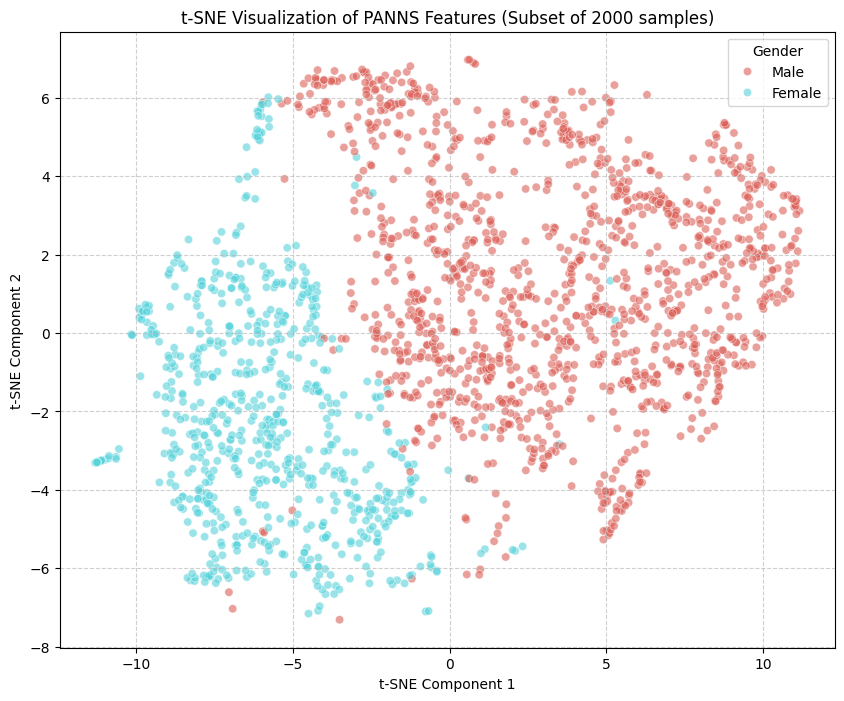

In [36]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Use the already loaded features and metadata
if 'features' not in locals() or 'metadata' not in locals():
    print("Error: Features or metadata not found. Please run the feature extraction steps first.")
else:
    print("Visualizing features for each set using t-SNE...")

    # Extract labels once
    y = metadata['gender'].map({'male': 0, 'female': 1}).values

    # Limiting to a smaller subset for faster visualization
    subset_size = 2000
    indices = np.random.choice(len(y), subset_size, replace=False)


    for feature_name, feature_array in features.items():
        print(f"\nVisualizing {feature_name} features...")

        X = feature_array[indices]
        y_subset = y[indices]

        # Apply PCA for initial dimensionality reduction
        if X.shape[1] > 50:
            try:
                pca = PCA(n_components=min(50, X.shape[1]), random_state=42)
                X_pca = pca.fit_transform(X)
                print(f"  PCA reduced to {X_pca.shape[1]} components, retaining {pca.explained_variance_ratio_.sum():.4f} variance.")
                X_tsne_input = X_pca
            except Exception as e:
                print(f"  PCA failed for {feature_name}: {e}. Using original features for t-SNE.")
                X_tsne_input = X
        else:
            X_tsne_input = X

        # Apply t-SNE for visualization
        try:
            tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
            X_tsne = tsne.fit_transform(X_tsne_input)

            # Create a DataFrame for plotting
            tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE-1', 'TSNE-2'])
            tsne_df['Gender'] = y_subset

            # Map numerical labels back to string names for plotting
            tsne_df['Gender'] = tsne_df['Gender'].map({0: 'Male', 1: 'Female'})


            # Plot the t-SNE results
            plt.figure(figsize=(10, 8))
            sns.scatterplot(
                x="TSNE-1", y="TSNE-2",
                hue="Gender",
                palette=sns.color_palette("hls", 2),
                data=tsne_df,
                legend="full",
                alpha=0.6
            )
            plt.title(f't-SNE Visualization of {feature_name.upper()} Features (Subset of {subset_size} samples)')
            plt.xlabel('t-SNE Component 1')
            plt.ylabel('t-SNE Component 2')
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.show()
        except Exception as e:
             print(f"  t-SNE visualization failed for {feature_name}: {e}")

Valid samples: 16148 (Male: 10380, Female: 5768)
Using device: cuda
Graph info: 16148 nodes, 161480 edges

Training and Evaluating GCN with VGGish features


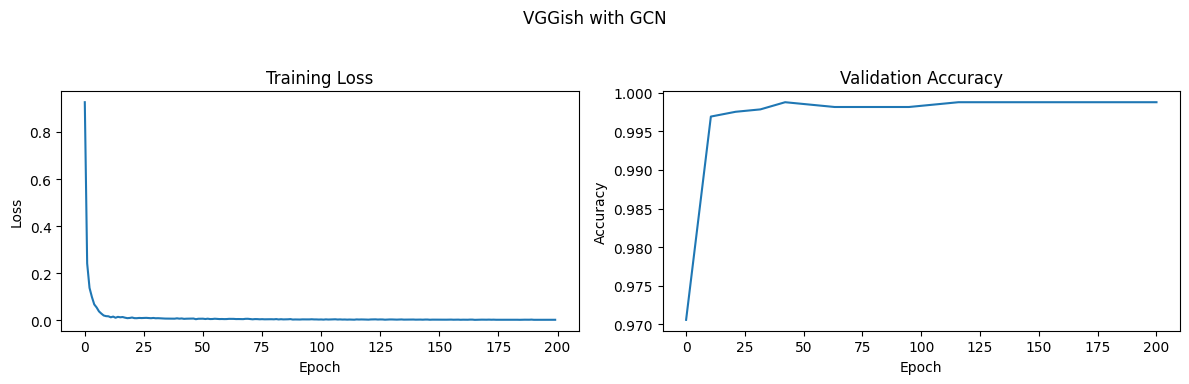

--- GCN with VGGish Metrics ---
Accuracy: 0.9988
Precision: 0.9988
Recall: 0.9988
F1-Score: 0.9988
Training Time: 2.04 seconds
-------------------------------

Training and Evaluating GAT with VGGish features


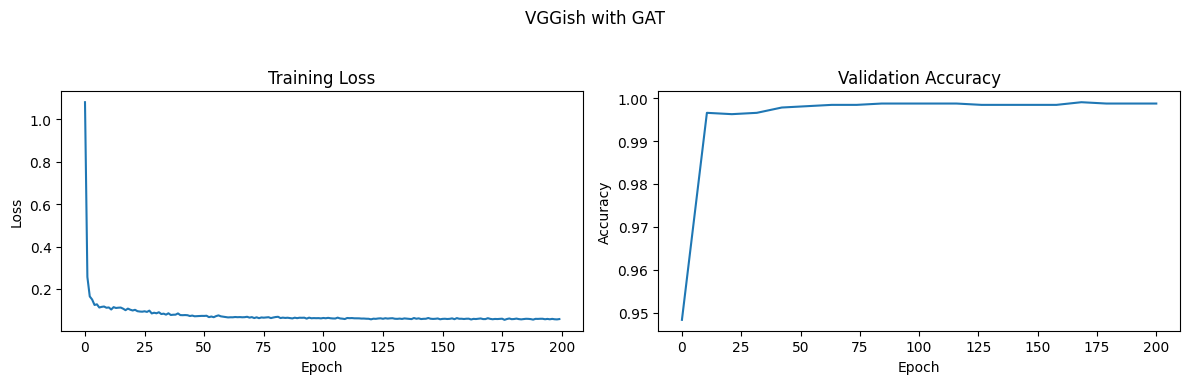

--- GAT with VGGish Metrics ---
Accuracy: 0.9988
Precision: 0.9988
Recall: 0.9988
F1-Score: 0.9988
Training Time: 2.85 seconds
-------------------------------

Training and Evaluating GraphSAGE with VGGish features


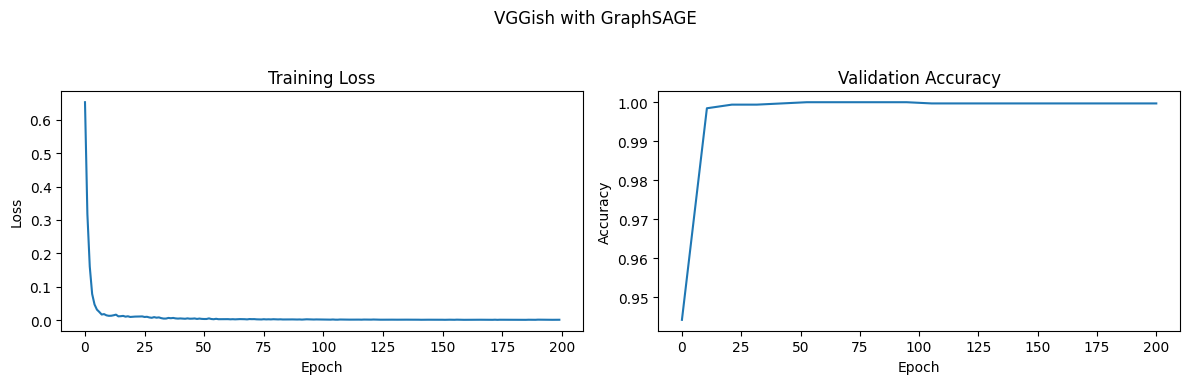

--- GraphSAGE with VGGish Metrics ---
Accuracy: 0.9997
Precision: 0.9997
Recall: 0.9997
F1-Score: 0.9997
Training Time: 1.67 seconds
-------------------------------------
Graph info: 16148 nodes, 161480 edges

Training and Evaluating GCN with YAMNet features


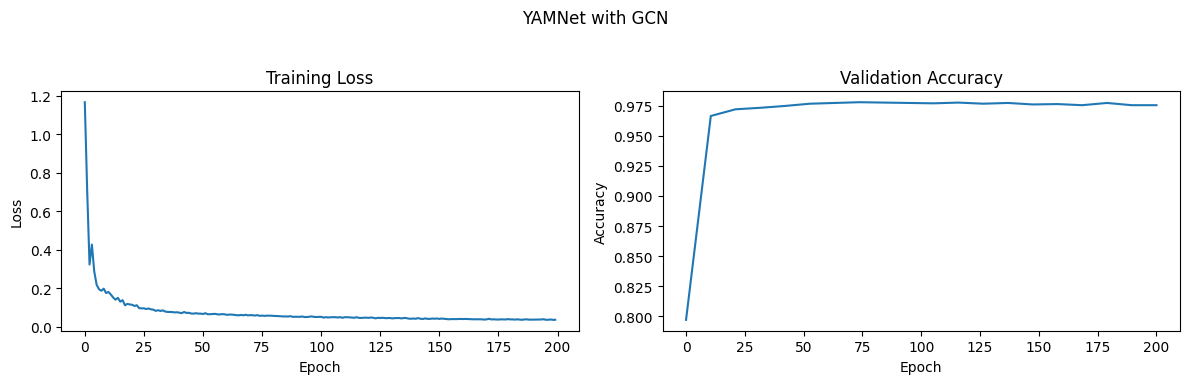

--- GCN with YAMNet Metrics ---
Accuracy: 0.9768
Precision: 0.9768
Recall: 0.9768
F1-Score: 0.9768
Training Time: 2.20 seconds
-------------------------------

Training and Evaluating GAT with YAMNet features


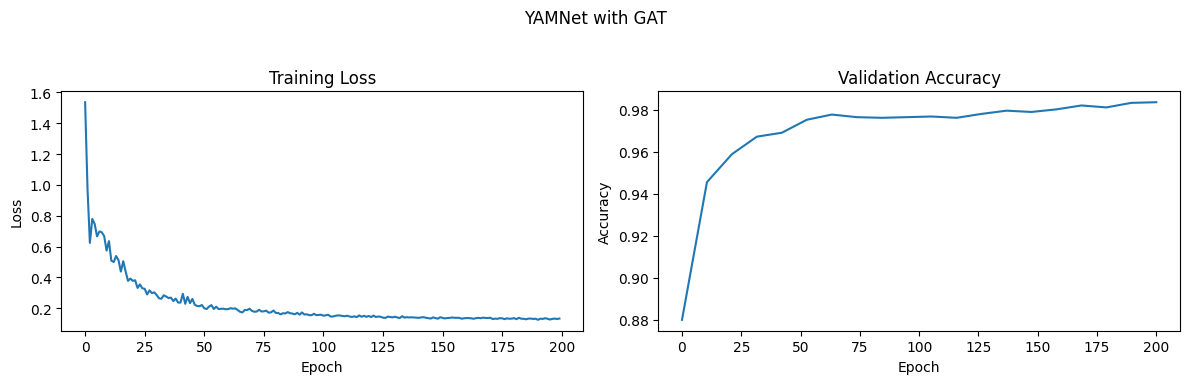

--- GAT with YAMNet Metrics ---
Accuracy: 0.9814
Precision: 0.9816
Recall: 0.9814
F1-Score: 0.9815
Training Time: 3.11 seconds
-------------------------------

Training and Evaluating GraphSAGE with YAMNet features


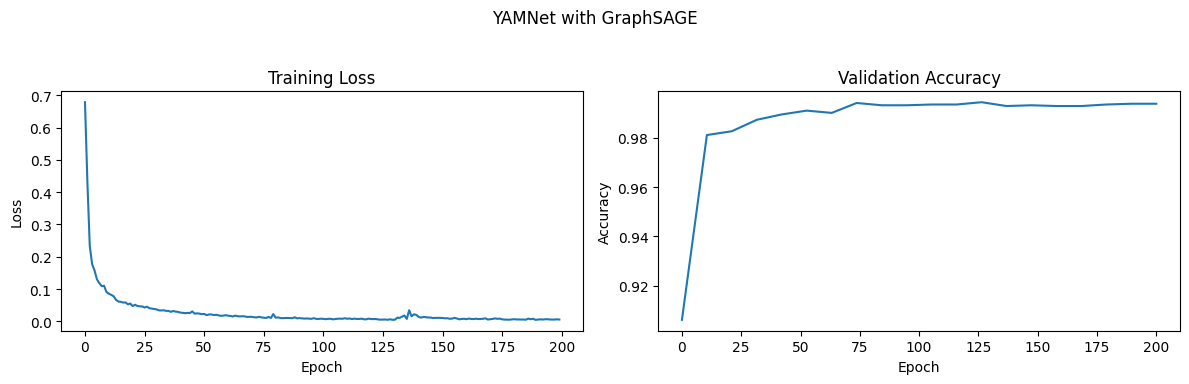

--- GraphSAGE with YAMNet Metrics ---
Accuracy: 0.9935
Precision: 0.9935
Recall: 0.9935
F1-Score: 0.9935
Training Time: 5.17 seconds
-------------------------------------
Graph info: 16148 nodes, 161480 edges

Training and Evaluating GCN with PANNs features


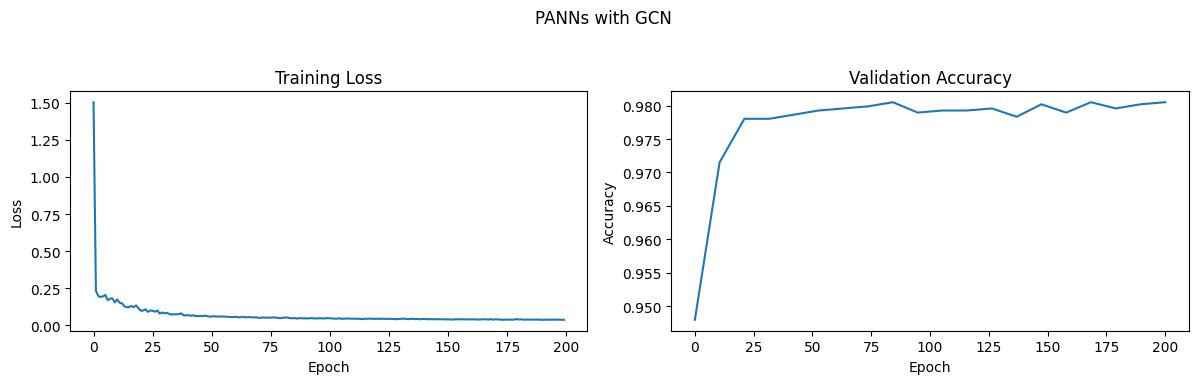

--- GCN with PANNs Metrics ---
Accuracy: 0.9802
Precision: 0.9802
Recall: 0.9802
F1-Score: 0.9802
Training Time: 2.38 seconds
------------------------------

Training and Evaluating GAT with PANNs features


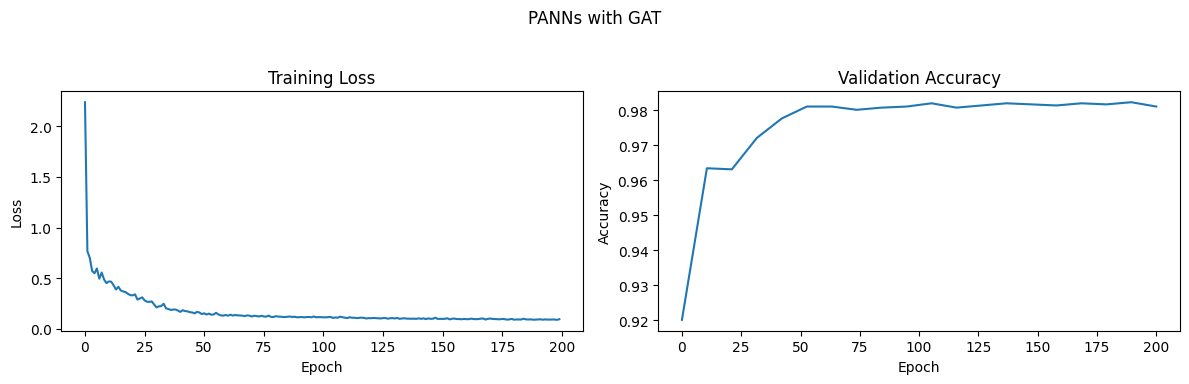

--- GAT with PANNs Metrics ---
Accuracy: 0.9820
Precision: 0.9821
Recall: 0.9820
F1-Score: 0.9821
Training Time: 3.56 seconds
------------------------------

Training and Evaluating GraphSAGE with PANNs features


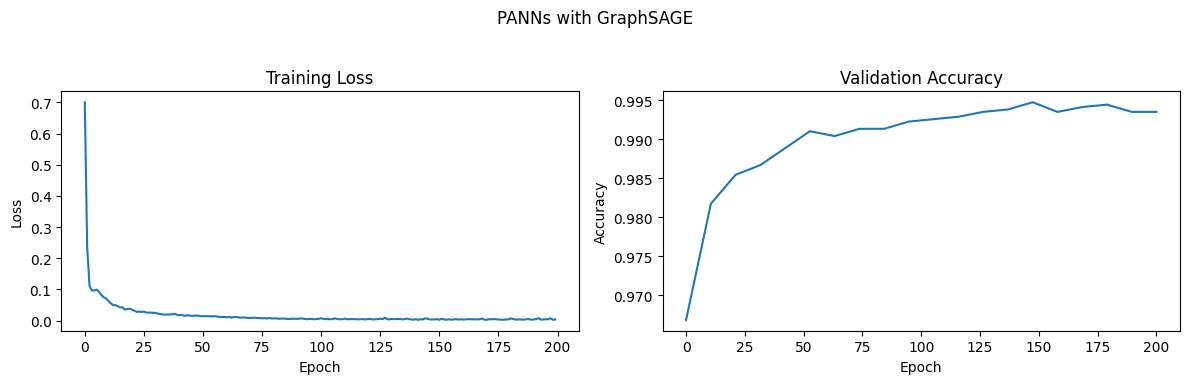

--- GraphSAGE with PANNs Metrics ---
Accuracy: 0.9932
Precision: 0.9932
Recall: 0.9932
F1-Score: 0.9932
Training Time: 9.28 seconds
------------------------------------

FINAL PERFORMANCE COMPARISON

Performance Metrics per Model and Feature:
|                  | accuracy   | precision   | recall   | f1_score   | training_time   |
|:-----------------|:-----------|:------------|:---------|:-----------|:----------------|
| VGGish_GCN       | 0.9988     | 0.9988      | 0.9988   | 0.9988     | 2.0430          |
| VGGish_GAT       | 0.9988     | 0.9988      | 0.9988   | 0.9988     | 2.8498          |
| VGGish_GraphSAGE | 0.9997     | 0.9997      | 0.9997   | 0.9997     | 1.6694          |
| YAMNet_GCN       | 0.9768     | 0.9768      | 0.9768   | 0.9768     | 2.2040          |
| YAMNet_GAT       | 0.9814     | 0.9816      | 0.9814   | 0.9815     | 3.1102          |
| YAMNet_GraphSAGE | 0.9935     | 0.9935      | 0.9935   | 0.9935     | 5.1721          |
| PANNs_GCN        | 0.9802     | 0.9

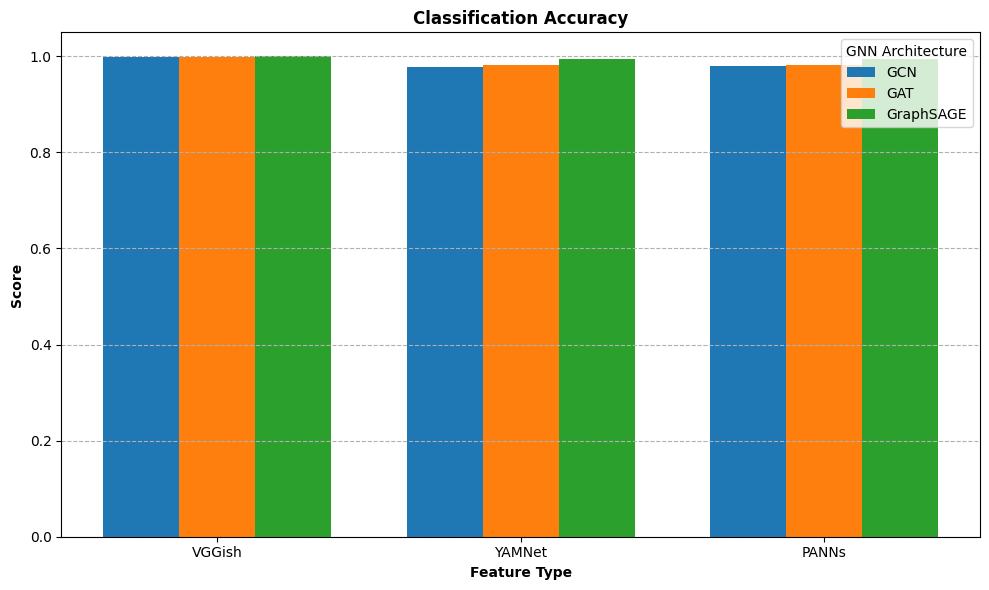

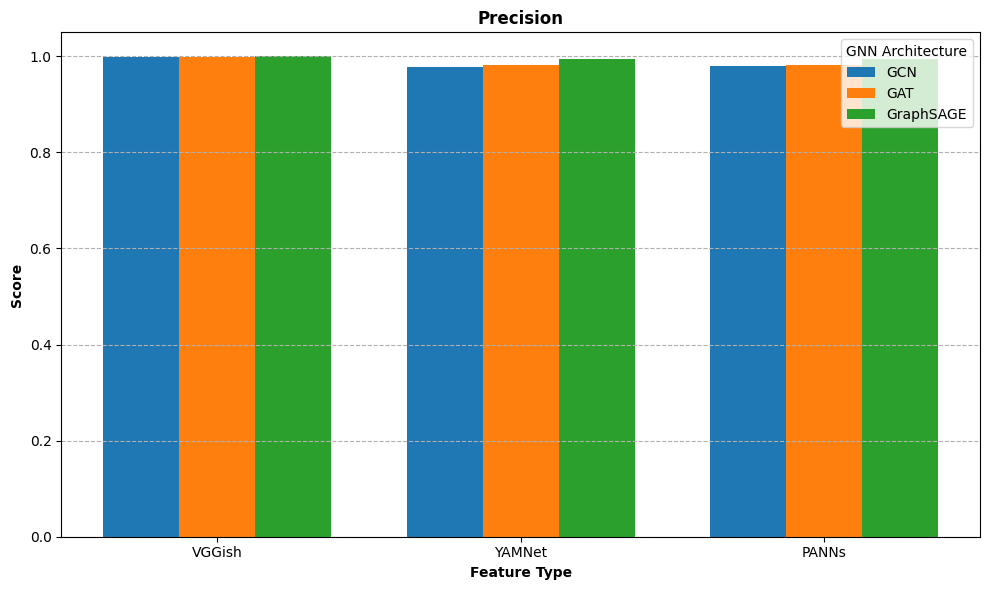

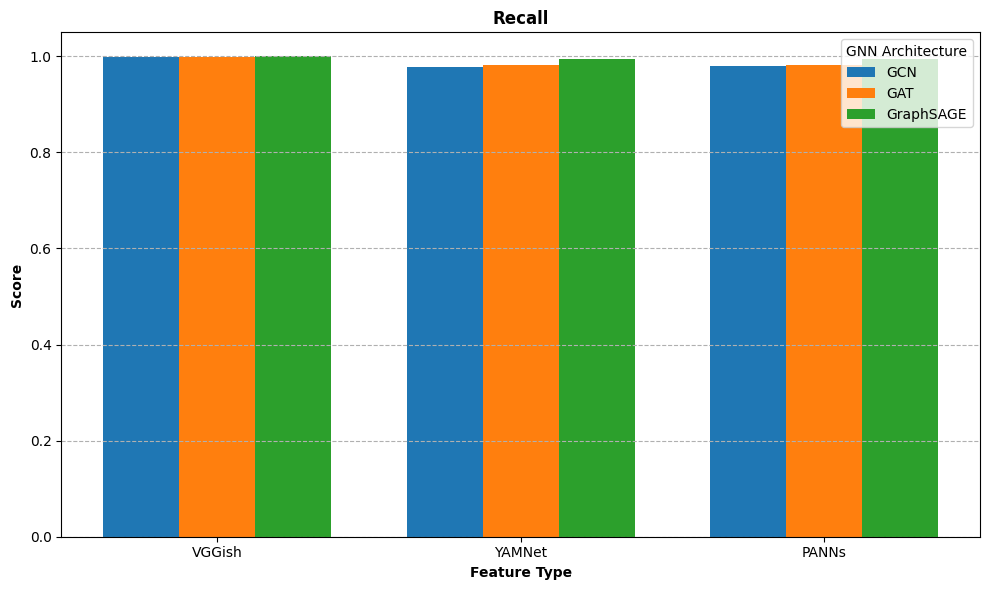

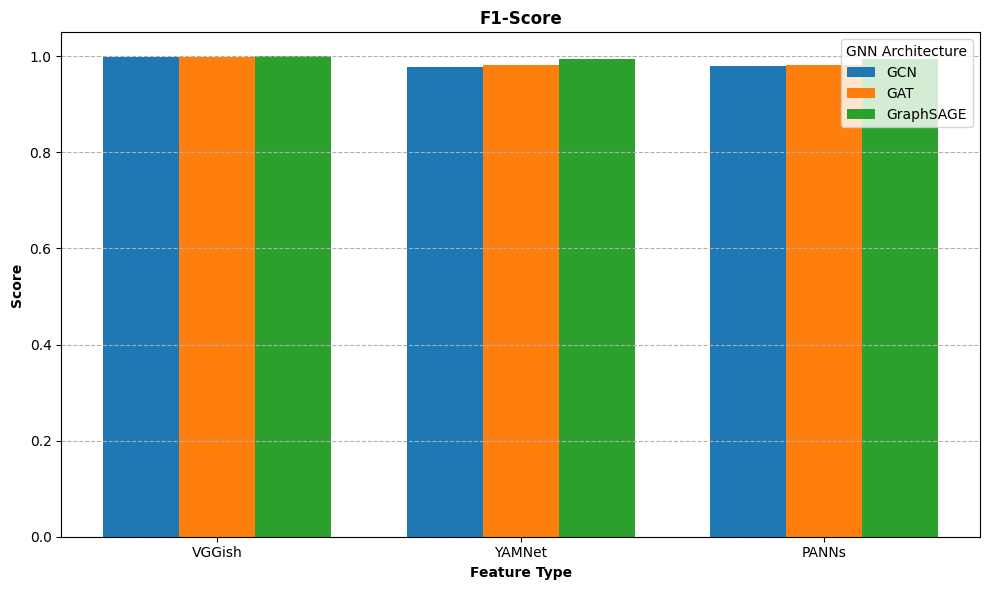

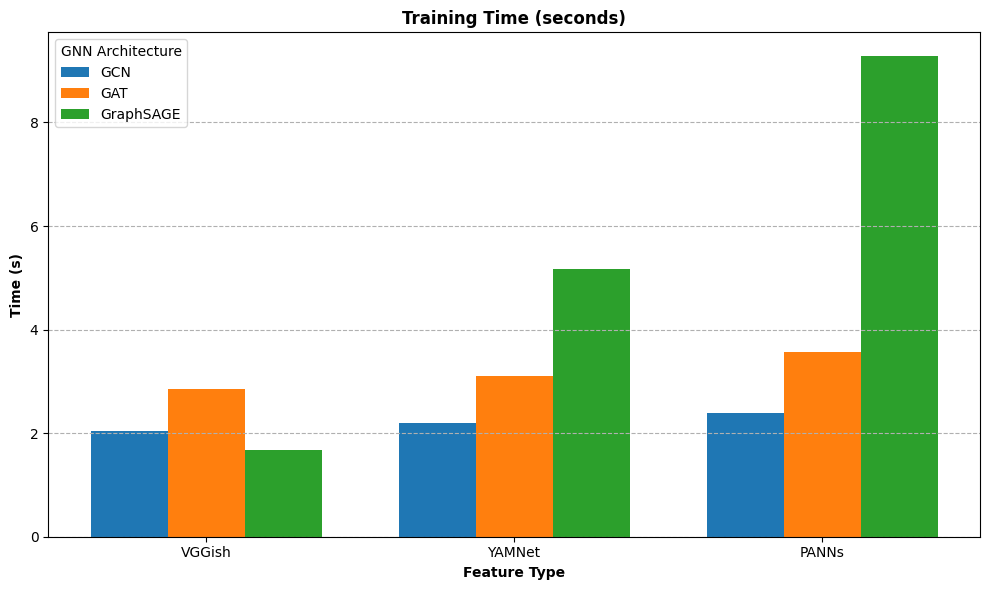


VISUALIZATION OF BASELINE vs GNN RESULTS


<Figure size 1200x600 with 0 Axes>

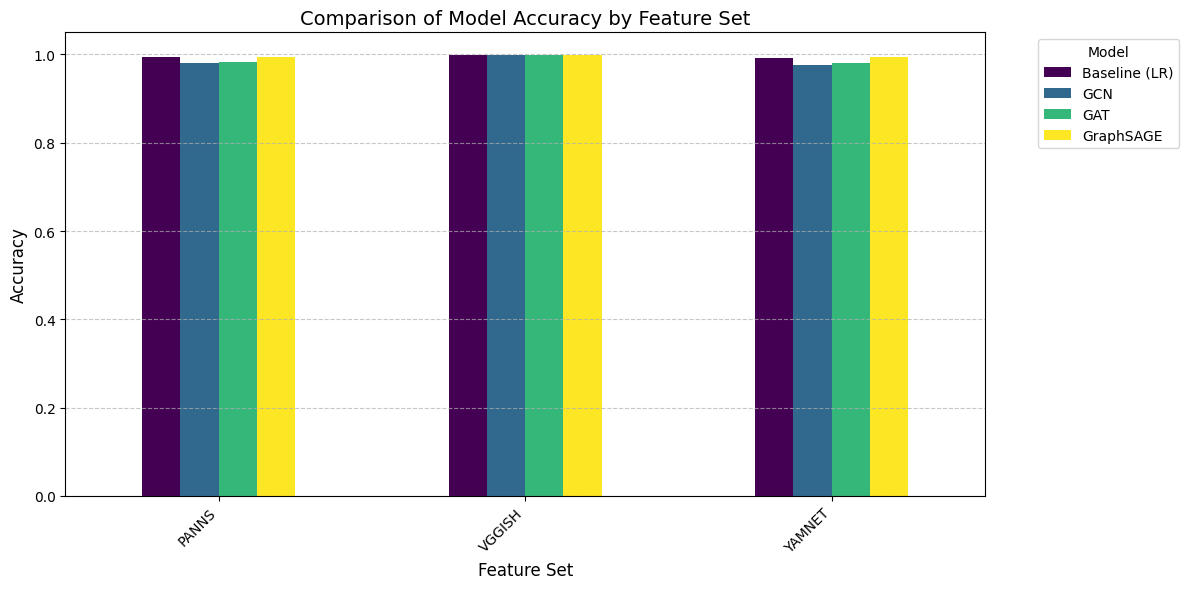


Accuracy Comparison:
| Feature   | Baseline (LR)   | GCN    | GAT    | GraphSAGE   |
|:----------|:----------------|:-------|:-------|:------------|
| PANNS     | 0.9944          | 0.9802 | 0.9820 | 0.9932      |
| VGGISH    | 0.9992          | 0.9988 | 0.9988 | 0.9997      |
| YAMNET    | 0.9917          | 0.9768 | 0.9814 | 0.9935      |


In [55]:
# ==========================================
# Step 10: Comparison of GNN architectures with the baseline model
# ==========================================
if 'main' in locals():

  gnn_results = main()
else:
  print("Error: main() function not found. Please ensure the cell containing the main function is executed.")
  gnn_results = {}


print("\n" + "="*50)
print("VISUALIZATION OF BASELINE vs GNN RESULTS")
print("="*50)

comparison_data = []

# Add baseline results
if 'baseline_results_df' in locals():
    for index, row in baseline_results_df.iterrows():
        comparison_data.append({
            'Model': 'Baseline (LR)',
            'Feature': index.upper(),
            'Accuracy': row['accuracy']
        })
else:
    print("Warning: Baseline results DataFrame (baseline_results_df) not found. Skipping baseline visualization.")

for key, value in gnn_results.items():
    parts = key.split('_')
    feature_name = parts[0]
    model_name = "_".join(parts[1:])

    if isinstance(value, dict) and 'accuracy' in value:
        accuracy = value['accuracy']
    elif isinstance(value, float):
        accuracy = value
    else:
        print(f"Warning: Unexpected data format for {key}. Skipping.")
        continue



    comparison_data.append({
        'Model': model_name,
        'Feature': feature_name.upper(),
        'Accuracy': accuracy

    })
comparison_df = pd.DataFrame(comparison_data)


pivot_df = comparison_df.pivot_table(index='Feature', columns='Model', values='Accuracy')

model_order = ['Baseline (LR)', 'GCN', 'GAT', 'GraphSAGE']
existing_cols = [col for col in model_order if col in pivot_df.columns]
pivot_df = pivot_df[existing_cols]

# Plotting the comparison
plt.figure(figsize=(12, 6))
pivot_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')

plt.title('Comparison of Model Accuracy by Feature Set', fontsize=14)
plt.xlabel('Feature Set', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 1.05)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nAccuracy Comparison:")
print(pivot_df.to_markdown(numalign="left", stralign="left", floatfmt=".4f"))